In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from scipy.integrate import odeint
from scipy.stats import spearmanr

from ipywidgets import interact, FloatSlider, Dropdown, IntSlider
from IPython.display import display, Image

from functools import reduce

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, r2_score)

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

from graphviz import Digraph

# Dengue In latin America (2020–2024): An Integrated Modeling Approach

Dengue fever is a mosquito-borne viral disease that represents a significant public health challenge in tropical and subtropical regions around the world. In Latin America, dengue has become endemic in many countries, with seasonal outbreaks that strain public health systems and disproportionately affect vulnerable populations. According to the Pan American Health Organization (PAHO), millions of cases are reported annually in the region, with substantial underreporting likely masking the true burden of the disease.

In this project, I present a comprehensive analysis of the Dengue situation in 10 Latin American countries between 2020 and 2024.

Our main goal is to investigate the epidemic dynamics of Dengue and explore the influence of socioeconomic and environmental factors on its spread and severity. By combining epidemiological modeling, machine learning, and data visualization, the aim is to answer critical questions:

- How has Dengue evolved in the region in recent years?
- What factors are most associated with an increase in Dengue cases or severity?
- Can we build predictive models to classify or estimate Dengue risk?

To achieve this, we employed three main approaches:
1. A **SIR epidemiological model** to simulate infection dynamics,
2. **Regression models** to estimate the number of Dengue cases based on explanatory variables,
3. **Classification models** to predict Dengue risk levels (low, medium, high).

This multidisciplinary pipeline provides a holistic view of Dengue as not only a biological phenomenon but also a reflection of broader socioeconomic conditions.


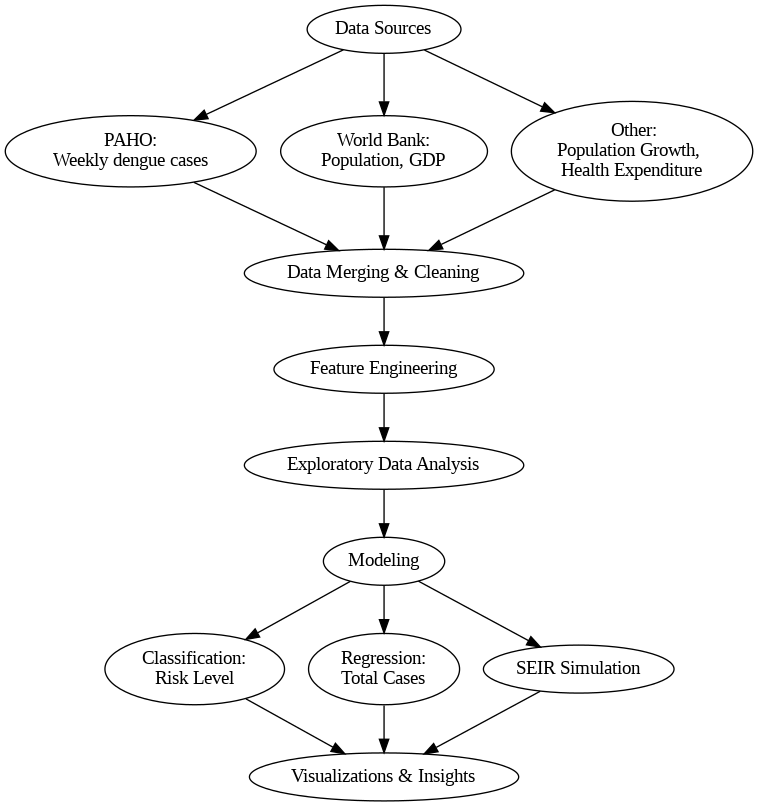

In [2]:
dot = Digraph(comment='Extended Dengue Project Workflow')

# Livello 1: Data Sources
dot.node('S', 'Data Sources')
dot.node('S1', 'PAHO:\nWeekly dengue cases')
dot.node('S2', 'World Bank:\nPopulation, GDP')
dot.node('S3', ' Other:\nPopulation Growth, \nHealth Expenditure')

dot.edges([('S', 'S1'), ('S', 'S2'), ('S', 'S3')])

# Livello 2: Merging & Cleaning
dot.node('A', 'Data Merging & Cleaning')
dot.edges([('S1', 'A'), ('S2', 'A'), ('S3', 'A')])

# Livello 3: Feature Engineering
dot.node('B', 'Feature Engineering')
dot.edge('A', 'B')

# Livello 4: EDA
dot.node('C', 'Exploratory Data Analysis')
dot.edge('B', 'C')

# Livello 5: Modeling
dot.node('D', 'Modeling')
dot.node('D1', 'Classification:\nRisk Level')
dot.node('D2', 'Regression:\nTotal Cases')

dot.edge('C', 'D')
dot.edges([('D', 'D1'), ('D', 'D2')])

# Livello 6: SIR Model
dot.node('E', 'SEIR Simulation')
dot.edge('D', 'E')

# Livello 7: Final
dot.node('F', 'Visualizations & Insights')
dot.edges([('D1', 'F'), ('D2', 'F'), ('E', 'F')])

# Visualizza nel notebook
Image(dot.pipe(format='png'))

# Data Overview




In [3]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/Dengue/'

Mounted at /content/drive


In [4]:
paho = pd.read_csv(base_path + 'PAHO_dengue.csv')
display(paho.head(3))

,Region,Country,Year,Dengue,Dengue grave,Muertes,Proporcion dengue grave,Total
0,Andean Subregion,Colombia,2020,78082,897.0,55,1.135745,78979
1,Central America Ithsmus and Mexico,Mexico,2020,119581,1058.0,79,0.876997,120639
2,Southern Cone,Argentina,2020,59271,87.0,19,0.146568,59358


## Dataset Construction and Feature Engineering

The original dataset was built manually by collecting annual Dengue-related indicators from PAHO (Pan American Health Organization), country by country and year by year, for the period 2020–2024. For each country, we gathered the number of confirmed Dengue cases, severe cases, and deaths. Missing values were imputed with zero where appropriate.

After cleaning the raw data, we manually enriched the dataset by adding population data retrieved online for each country-year combination. This enabled us to compute key derived epidemiological indicators:

- `severe_ratio`: proportion of severe cases over total cases,
- `incidence_per_100k`: incidence rate per 100,000 people,
- `mortality_rate_per_100k`: deaths per 100,000 people,
- `cfr_per_100k`: case fatality rate (CFR) per 100,000 confirmed cases.

To ensure temporal consistency, the dataset was sorted by country and year. Infinite values were removed, and missing CFR values were set to 0.

Lastly, we created a categorical variable called `risk_level` by applying a **quantile-based classification (`qcut`)** on the `incidence_per_100k`, splitting it into three levels: *low*, *medium*, and *high*. This variable was later used for classification models.

In [5]:
paho.columns = [
    "region",
    "country",
    "year",
    "dengue_cases",
    "severe_cases",
    "deaths",
    "severe_ratio",
    "total_cases"
]

In [6]:
print(paho.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        50 non-null     object 
 1   country       50 non-null     object 
 2   year          50 non-null     int64  
 3   dengue_cases  50 non-null     int64  
 4   severe_cases  49 non-null     float64
 5   deaths        50 non-null     int64  
 6   severe_ratio  49 non-null     float64
 7   total_cases   50 non-null     int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 3.3+ KB
None


In [7]:
paho["severe_cases"] = paho["severe_cases"].fillna(0).astype(int)
paho["severe_ratio"] = (paho["severe_ratio"].fillna(0).astype(float))

In [8]:
#data from Dati Macro / Worldometer / Statista

pop_data = {
    'Colombia': {
        2020: 50629997,
        2021: 51188173,
        2022: 51737944,
        2023: 52321152,
        2024: 52886363
    },
    'Mexico': {
        2020: 125950000,
        2021: 126650000,
        2022: 127500000,
        2023: 128420000,
        2024: 129150000
    },
    'Argentina': {
        2020: 45380000,
        2021: 45810000,
        2022: 46230000,
        2023: 46620000,
        2024: 46940000
    },
    'Brazil': {
        2020: 212560000,
        2021: 213990000,
        2022: 215310000,
        2023: 216420000,
        2024: 217240000
    },
    'Ecuador': {
        2020: 17400000,
        2021: 17700000,
        2022: 17900000,
        2023: 18200000,
        2024: 18300000
    },
    'Peru': {
        2020: 33000000,
        2021: 33400000,
        2022: 33700000,
        2023: 34000000,
        2024: 34400000
    },
    'El Salvador': {
        2020: 6300000,
        2021: 6300000,
        2022: 6300000,
        2023: 6400000,
        2024: 6400000
    },
    'Guatemala': {
        2020: 17000000,
        2021: 17300000,
        2022: 17600000,
        2023: 17900000,
        2024: 18100000
    },
    'Honduras': {
        2020: 9900000,
        2021: 10100000,
        2022: 10300000,
        2023: 10400000,
        2024: 10600000
    },
    'Paraguay': {
        2020: 7100000,
        2021: 7200000,
        2022: 7300000,
        2023: 7400000,
        2024: 7500000
    }
}

paho['population'] = paho.apply(
    lambda row: pop_data.get(row['country'], {}).get(row['year'], None),
    axis=1
)

paho = paho[[
    'region',
    'country',
    'year',
    'population',
    'dengue_cases',
    'severe_cases',
    'total_cases',
    'deaths',
    'severe_ratio'
]]

In [9]:
paho = paho.copy()
paho.loc[:, 'severe_ratio'] = paho['severe_ratio'].round(4)
paho.loc[:, 'incidence_per_100k'] = ((paho['total_cases'] / paho['population']) * 100000).round(4)
paho.loc[:, 'mortality_rate_per_100k'] = ((paho['deaths'] / paho['population']) * 100000).round(4)
paho.loc[:, 'cfr_per_100k'] = (paho['deaths'] / paho['total_cases']) * 100000

paho.sort_values(by=['country', 'year'], inplace=True)

paho.replace([np.inf, -np.inf], np.nan, inplace=True)

paho['cfr_per_100k'] = paho['cfr_per_100k'].fillna(0).round(4)
paho['risk_level'] = pd.qcut(paho['incidence_per_100k'], q=3, labels=['low', 'medium', 'high'])

In [10]:
display(paho.head(5))

,region,country,year,population,dengue_cases,severe_cases,total_cases,deaths,severe_ratio,incidence_per_100k,mortality_rate_per_100k,cfr_per_100k,risk_level
2,Southern Cone,Argentina,2020,45380000,59271,87,59358,19,0.1466,130.8021,0.0419,32.0092,low
6,Southern Cone,Argentina,2021,45810000,3972,0,3972,0,0.0000,8.6706,0.0000,0.0000,low
10,Southern Cone,Argentina,2022,46230000,837,4,841,0,0.4756,1.8192,0.0000,0.0000,low
14,Southern Cone,Argentina,2023,46620000,146615,261,146876,75,0.1777,315.0493,0.1609,51.0635,medium
18,Southern Cone,Argentina,2024,46940000,579955,1604,581559,408,0.2758,1238.9412,0.8692,70.1563,high


## Integration of Socioeconomic and Environmental Indicators

To enhance the explanatory power of our Dengue dataset, we integrated several socioeconomic and environmental indicators retrieved from publicly available international datasets, including the World Bank and other development statistics platforms. The variables included were:

- **Health expenditure per capita (% of GDP)**,
- **Population density (people per km²)**,
- **Urban population growth rate (% annually)**,
- **Poverty (% of population below national poverty line)**,
- **Access to safely managed drinking water (% of population)**.

Each dataset was originally in wide format (years as columns), containing data for a large number of countries and years. These tables were preprocessed to fit our analytical needs as follows:

1. **Missing year estimation**: For each country, if a value for a target year (2020–2024) was missing, it was estimated as the average of available values from the 10 preceding years (when possible).
2. **Reshaping**: Each table was transformed from wide to long format, creating one row per country-year-value triplet.
3. **Filtering**: Only the ten countries of interest in Latin America were retained.
4. **Cleaning & aggregation**: In the case of the poverty dataset, where multiple entries existed for a single country-year, values were averaged.
5. **Renaming and standardization**: Columns were renamed for clarity and interpretability, e.g., `health_expenditure` → `health_expenditure_%GDP`.

In the case of the `safe_water` variable (already in long format), only the relevant countries and years were kept. Missing values were imputed using the **country-specific average** over the available years.

Finally, all the cleaned indicator tables were merged using an **outer join** on `country` and `year`, and then joined with the Dengue dataset previously constructed. This resulted in a comprehensive dataset containing:

- Epidemiological data (cases, deaths, severity, risk level),
- Population data,
- Five external socioeconomic indicators.

An example of the final integrated dataset is shown below:


In [11]:
health_expenditure = pd.read_csv(base_path + 'HE_pro_capita.csv', skiprows=4)
pop_density = pd.read_csv(base_path + 'pop_density.csv', skiprows=4)
pop_rate = pd.read_csv(base_path + 'pop_rate.csv', skiprows=4)
poverty = pd.read_csv(base_path + 'poverty.csv', skiprows=4)
safe_water = pd.read_csv(base_path + 'safe_water.csv', skiprows=0)

In [12]:
def preprocess_table(df, countries, years_to_use, id_vars):
    # Stima valori mancanti per anni richiesti
    def estimate_years(row):
        for year in years_to_use:
            if year not in row or pd.isna(row[year]):
                prev_years = [str(int(year) - i) for i in range(1, 11) if str(int(year) - i) in df.columns]
                prev_values = [row[y] for y in prev_years if not pd.isna(row[y])]
                if prev_values:
                    row[year] = np.mean(prev_values)
                else:
                    row[year] = np.nan
        return row

    df = df.apply(estimate_years, axis=1)

    # Trasforma da wide a long
    df_long = df.melt(id_vars=id_vars, value_vars=years_to_use, var_name='year', value_name='value')

    # Filtra per paesi
    df_long = df_long[df_long['Country Name'].isin(countries)]

    return df_long

# Lista anni target
years_to_use = [str(y) for y in range(2020, 2025)]

# Lista paesi interessati
countries = paho.country.unique()

# Identificatori colonne per tabelle wide
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']

# Preprocessa le tabelle wide
health_long = preprocess_table(health_expenditure, countries, years_to_use, id_vars)
pop_density_long = preprocess_table(pop_density, countries, years_to_use, id_vars)
pop_rate_long = preprocess_table(pop_rate, countries, years_to_use, id_vars)
poverty_long = preprocess_table(poverty, countries, years_to_use, id_vars)

# Rimuovi duplicati da poverty facendo la media (per country+year)
poverty_long_clean = poverty_long.groupby(['Country Name', 'year'])['value'].mean().reset_index()
poverty_long_clean.rename(columns={'value': 'poverty'}, inplace=True)

# Per le altre tabelle senza duplicati, solo rinomina la colonna
health_long_clean = health_long.rename(columns={'value': 'health_expenditure'})
pop_density_long_clean = pop_density_long.rename(columns={'value': 'pop_density'})
pop_rate_long_clean = pop_rate_long.rename(columns={'value': 'pop_rate'})

# Per safe_water, filtro e rinomina (già in formato long)
safe_water_long = safe_water[
    (safe_water['Entity'].isin(countries)) &
    (safe_water['Year'].between(2020, 2024))
].copy()
safe_water_long.rename(columns={
    'Entity': 'Country Name',
    'Code': 'Country Code',
    'Year': 'year',
    'Share of the population using safely managed drinking water services': 'safe_water'
}, inplace=True)
safe_water_long['year'] = safe_water_long['year'].astype(str)

# Lista dataframes per merge
dfs = [
    health_long_clean[['Country Name', 'year', 'health_expenditure']],
    pop_density_long_clean[['Country Name', 'year', 'pop_density']],
    pop_rate_long_clean[['Country Name', 'year', 'pop_rate']],
    poverty_long_clean[['Country Name', 'year', 'poverty']],
    safe_water_long[['Country Name', 'year', 'safe_water']]
]

# Merge finale su Country Name + year (inner join)
df_final = reduce(lambda left, right: pd.merge(left, right, on=['Country Name', 'year'], how='outer'), dfs)
# Imputazione media per safe_water per ogni paese
df_final['safe_water'] = df_final.groupby('Country Name')['safe_water'].transform(lambda x: x.fillna(x.mean()))
df_final = df_final.round(2)

# 1. Converti 'year' in intero
df_final['year'] = df_final['year'].astype(int)

# 3. Rinomina colonne per chiarezza
df_final.rename(columns={
    'health_expenditure': 'health_expenditure_%GDP',
    'pop_density': 'pop_density_people_per_km2',
    'pop_rate': 'urban_pop_growth_%_annum',
    'poverty': 'poverty_%population',
    'safe_water': 'safe_water_%population',
    'Country Name': 'country'
}, inplace=True)

dengue = pd.merge(paho, df_final, on=['country', 'year'], how='outer')
dengue = dengue.sort_values(['country', 'year']).reset_index(drop=True)

dengue['safe_water_%population'] = dengue['safe_water_%population'].fillna(dengue['safe_water_%population'].mean())

display(dengue.head(5))

,region,country,year,population,dengue_cases,severe_cases,total_cases,deaths,severe_ratio,incidence_per_100k,mortality_rate_per_100k,cfr_per_100k,risk_level,health_expenditure_%GDP,pop_density_people_per_km2,urban_pop_growth_%_annum,poverty_%population,safe_water_%population
0,Southern Cone,Argentina,2020,45380000,59271,87,59358,19,0.1466,130.8021,0.0419,32.0092,low,10.45,16.51,0.62,16.91,63.3645
1,Southern Cone,Argentina,2021,45810000,3972,0,3972,0,0.0000,8.6706,0.0000,0.0000,low,10.04,16.56,0.39,16.21,63.3645
2,Southern Cone,Argentina,2022,46230000,837,4,841,0,0.4756,1.8192,0.0000,0.0000,low,9.86,16.59,0.34,13.69,63.3645
3,Southern Cone,Argentina,2023,46620000,146615,261,146876,75,0.1777,315.0493,0.1609,51.0635,medium,10.06,16.18,0.41,13.95,63.3645
4,Southern Cone,Argentina,2024,46940000,579955,1604,581559,408,0.2758,1238.9412,0.8692,70.1563,high,10.08,16.24,0.80,13.97,63.3645


# Exploratory Visual Analysis
## Pearson Correlation Matrix


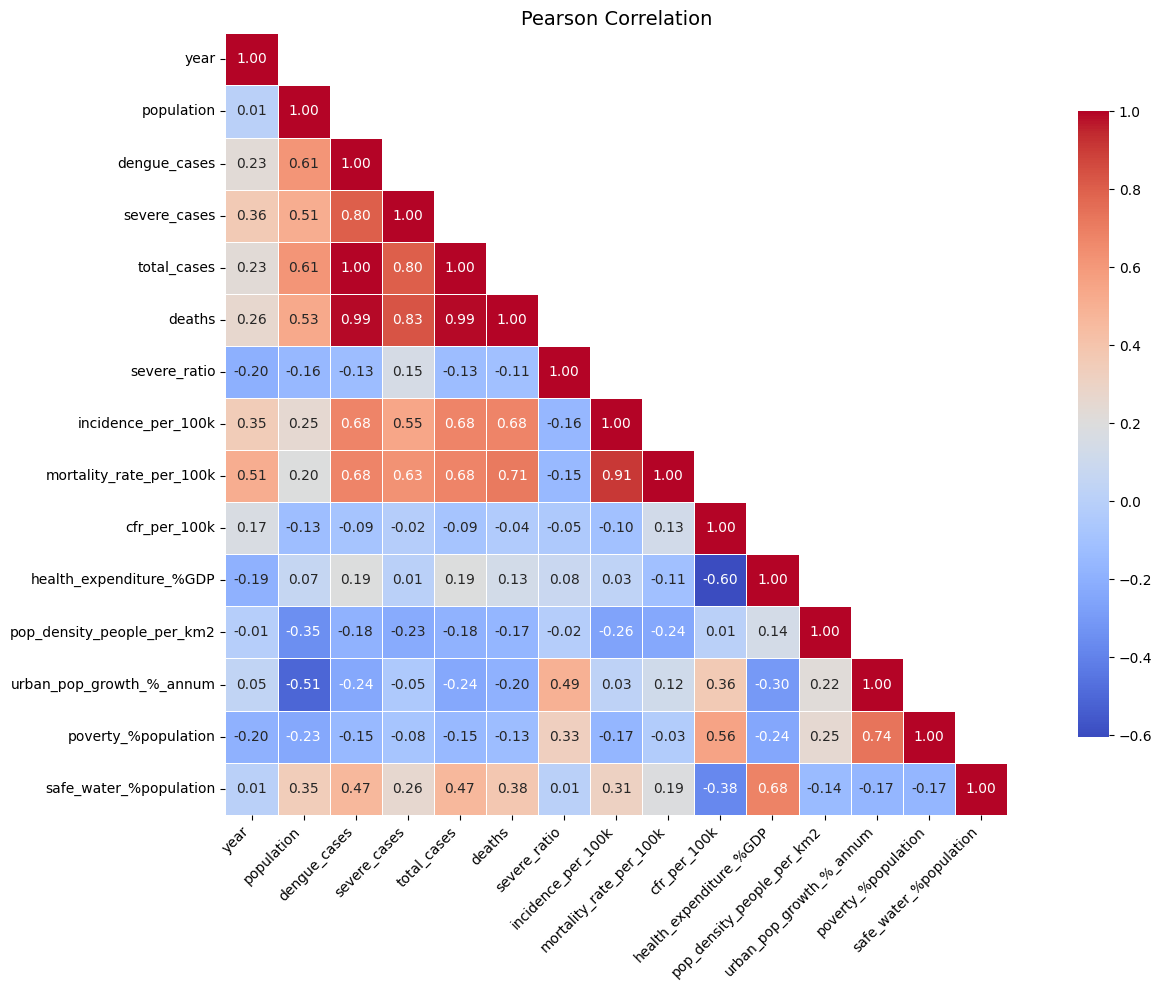

In [13]:
# Seleziona solo le colonne numeriche
df_numeric = dengue.select_dtypes(include=np.number)

# Calcola la matrice di correlazione
corr = df_numeric.corr()

# Crea la maschera per la triangolare superiore (sotto la diagonale viene mostrata)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Imposta il colore della diagonale su False per mostrarla
np.fill_diagonal(mask, False)

# Plot
plt.figure(figsize=(15, 10))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Pearson Correlation", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This heatmap displays the pairwise Pearson correlation coefficients among all quantitative variables in the dataset. Only the lower triangle of the matrix is shown to avoid redundancy.

Key observations:
- **Strong positive correlation** between `dengue_cases`, `total_cases`, and `deaths` (r ≈ 0.98), which confirms that total cases and deaths are tightly linked to the number of reported infections.
- `mortality_rate_per_100k` is strongly correlated with `incidence_per_100k` (r ≈ 0.91), suggesting that high incidence almost always implies a proportionally high mortality rate.
- `urban_pop_growth_%_annum` shows a **moderate positive correlation** with `severe_ratio` and `poverty_%population`, hinting that faster urban growth might be associated with less controlled environments where severe cases thrive.
- `health_expenditure_%GDP` is **negatively correlated** with `cfr_per_100k` (r ≈ -0.60), possibly indicating that higher health investment is associated with lower fatality rates.

This matrix was computed using Pearson correlation on all numerical features. A mask was applied to hide the upper triangle for clarity. The color gradient `coolwarm` emphasizes the direction and strength of relationships.


### Spearman Correlation Analysis: Monotonic Associations

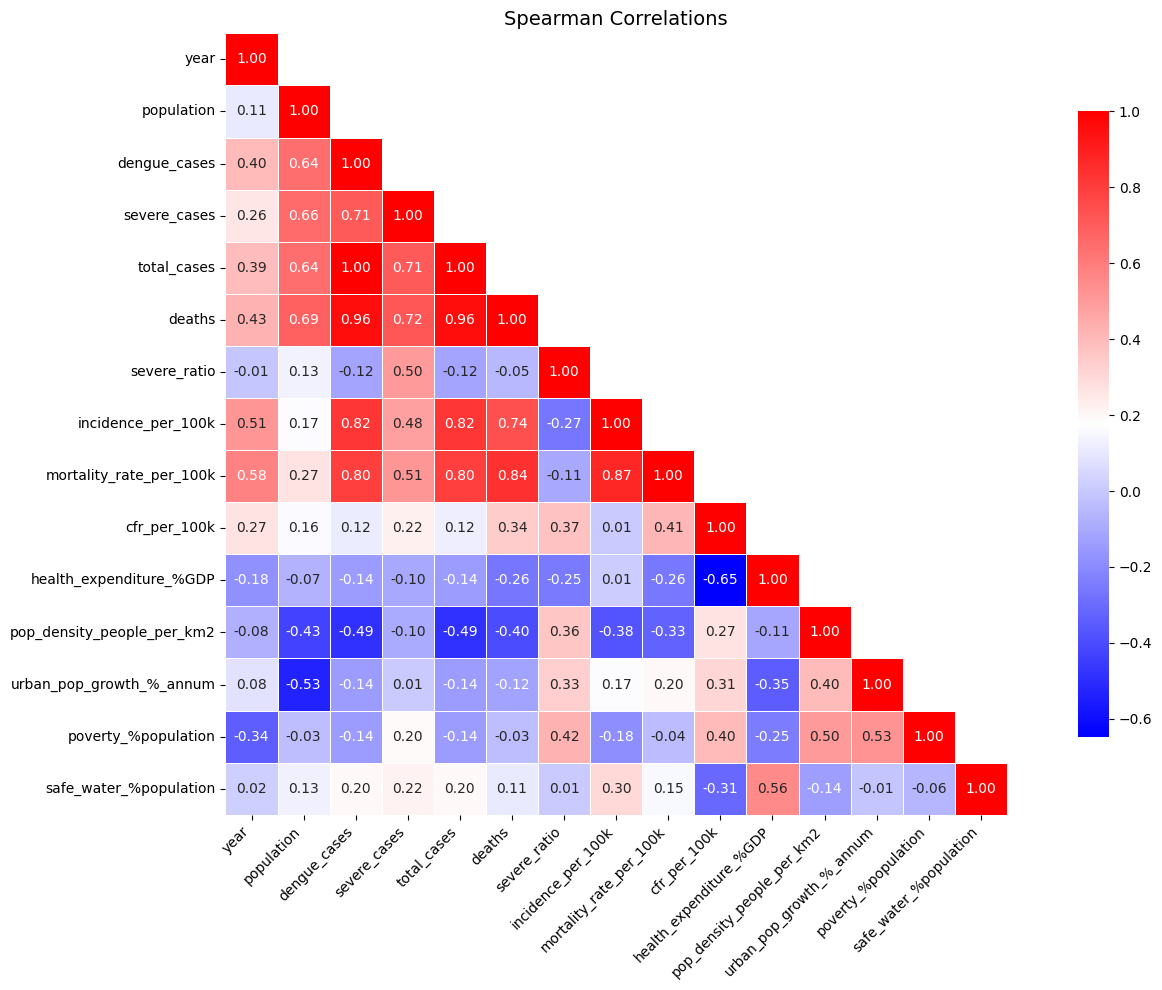

In [14]:
# Seleziona solo le colonne numeriche
df_numeric = dengue.select_dtypes(include=np.number)

# Calcola la matrice di correlazione Spearman
corr_spearman = df_numeric.corr(method='spearman')

# Crea la maschera per la triangolare superiore
mask = np.triu(np.ones_like(corr_spearman, dtype=bool), k=1)
np.fill_diagonal(mask, False)

# Plot della matrice Spearman
plt.figure(figsize=(15, 10))
sns.heatmap(
    corr_spearman,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="bwr",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Spearman Correlations", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In addition to Pearson's correlation, we applied **Spearman's rank correlation** to capture **monotonic but potentially non-linear relationships** among the quantitative variables in our dataset.

This method ranks the data before computing the correlation coefficient (ρ), making it more robust to:
- Non-normal distributions,
- Skewness and outliers,
- Non-linear but consistent trends.

#### Key Patterns Observed

- `dengue_cases`, `total_cases`, and `deaths` remain **strongly and positively correlated** (ρ ≈ 0.99), confirming the internal consistency of the disease burden indicators.
- `incidence_per_100k` and `mortality_rate_per_100k` show **very high monotonic correlation** (ρ > 0.90), slightly stronger than in Pearson, reflecting proportional increases across country-years.
- Socioeconomic indicators like `safe_water_%population` correlate **more clearly and positively** with `total_cases` and `dengue_cases` (ρ ≈ 0.47), suggesting an indirect pattern where better surveillance or infrastructure may lead to more reported cases.

#### Differences vs. Pearson Correlation

- The relationship between `urban_pop_growth_%_annum` and `severe_ratio` is **stronger in Spearman** (ρ = 0.49 vs. 0.33 in Pearson), highlighting a possible **non-linear or threshold effect** of urbanization on disease severity.
- `poverty_%population` and `cfr_per_100k` show **higher positive monotonic correlations** in Spearman (ρ = 0.55 vs. 0.39), suggesting a more consistent but possibly non-linear trend between poverty and case-fatality.
- Some variables (e.g. `population`, `pop_density_people_per_km2`) show **weaker correlations** than in Pearson, indicating their effects may be more linear or distorted by outliers.

This step strengthens the analysis by validating observed patterns under a more flexible statistical lens, and reveals subtle associations that may be overlooked with linear metrics alone.


### Comparing Pearson and Spearman Correlation Coefficients

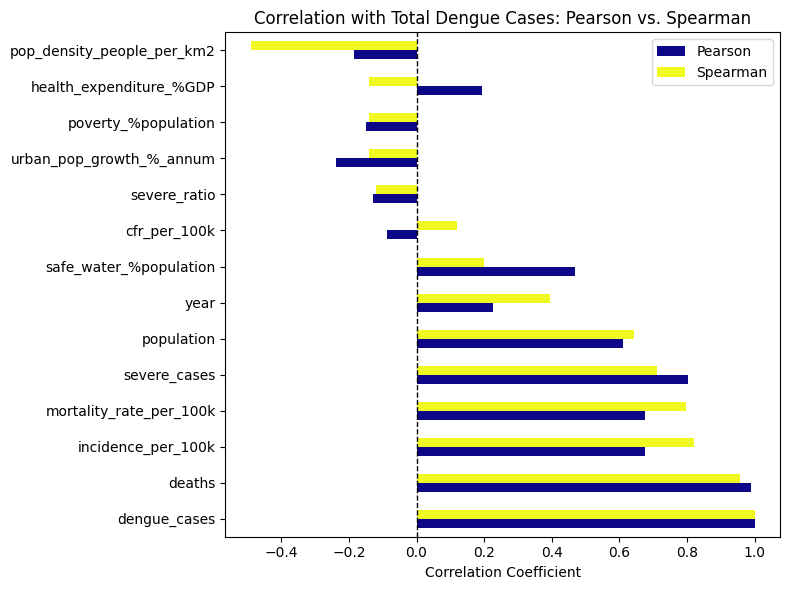

In [15]:
# Seleziona solo colonne numeriche
df_numeric = dengue.select_dtypes(include=np.number)
target_var = 'total_cases'

# Calcola entrambe le correlazioni
pearson_corr = df_numeric.corr(method='pearson')[target_var]
spearman_corr = df_numeric.corr(method='spearman')[target_var]

# Crea un DataFrame comparativo
corr_compare = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
}).drop(index=target_var)  # escludi la self-correlation

# Ordina per Spearman (puoi cambiare in 'Pearson' se preferisci)
corr_compare = corr_compare.sort_values(by='Spearman', ascending=False)

# Plot a barre
corr_compare.plot(kind='barh', figsize=(8, 6), colormap='plasma')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("Correlation with Total Dengue Cases: Pearson vs. Spearman")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

To highlight how correlation strength varies depending on the metric used, we compared **Pearson's linear correlation** and **Spearman's rank correlation** for each numerical variable with respect to `total_cases`.

The comparison reveals:

- Most variables maintain consistent correlation strength and direction, confirming robust associations.
- Some variables (e.g. `urban_pop_growth_%_annum`, `poverty_%population`, `safe_water_%population`) show **higher Spearman coefficients**, suggesting **non-linear but monotonic relationships**.
- Others (e.g. `pop_density_people_per_km2`) show **weaker Spearman correlation**, indicating that outliers or non-monotonic trends might distort linear metrics.

This dual perspective supports a more nuanced understanding of variable behavior in relation to Dengue incidence.

### Statistical Significance of Correlations (Spearman Test)

In [16]:
target = 'total_cases'
results = []

for col in dengue.select_dtypes(include='number').columns:
    if col != target:
        rho, p = spearmanr(dengue[target], dengue[col])
        results.append({'Variable': col, 'p_value': p})

spearman_table = pd.DataFrame(results).sort_values(by='p_value').reset_index(drop=True)
spearman_table_transposed = spearman_table.set_index('Variable').T

# Stampa arrotondata e trasposta
display(spearman_table_transposed.round(4))


Variable,dengue_cases,deaths,incidence_per_100k,mortality_rate_per_100k,severe_cases,population,pop_density_people_per_km2,year,safe_water_%population,health_expenditure_%GDP,poverty_%population,urban_pop_growth_%_annum,cfr_per_100k,severe_ratio
p_value,0.0,0.0,0.0,0.0,0.0,0.0,0.0003,0.0045,0.1664,0.3284,0.3292,0.3331,0.41,0.4107


We computed the p-values associated with Spearman correlation coefficients to assess the statistical significance of the relationships between each variable and the total number of Dengue cases (`total_cases`).

- Several variables, including `dengue_cases`, `deaths`, `incidence_per_100k`, `mortality_rate_per_100k`, `severe_cases`, and `population`, show **highly significant correlations** with p-values effectively equal to zero. This indicates very strong evidence that these associations are not due to random chance.

- Variables such as `pop_density_people_per_km2` and `year` also show statistically significant correlations with p-values below the conventional 0.05 threshold.

- Other socio-economic variables like `safe_water_%population`, `health_expenditure_%GDP`, `poverty_%population`, `urban_pop_growth_%_annum`, `cfr_per_100k`, and `severe_ratio` have higher p-values, suggesting weaker or non-significant monotonic relationships with Dengue cases in this dataset.

These results support the robustness of the key epidemiological indicators in explaining Dengue incidence, while suggesting that some socio-economic variables may have a more complex or indirect influence that requires further investigation.


## Socioeconomic and Environmental Factors vs Dengue Impact

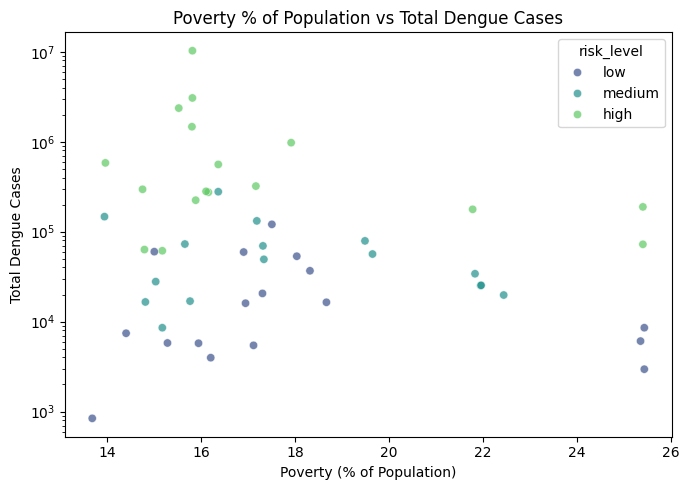

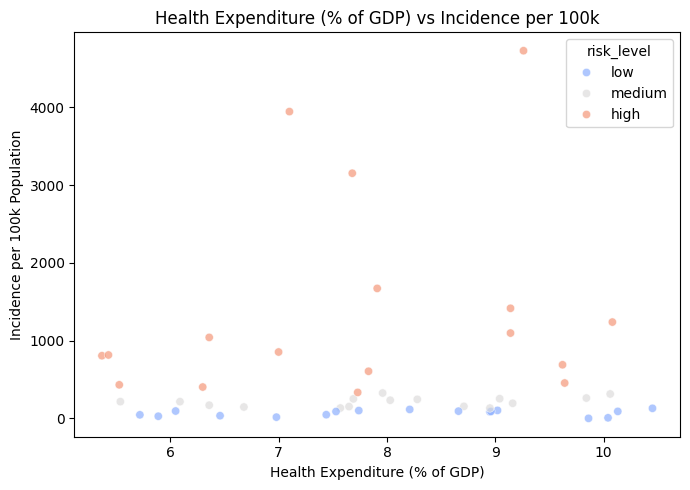

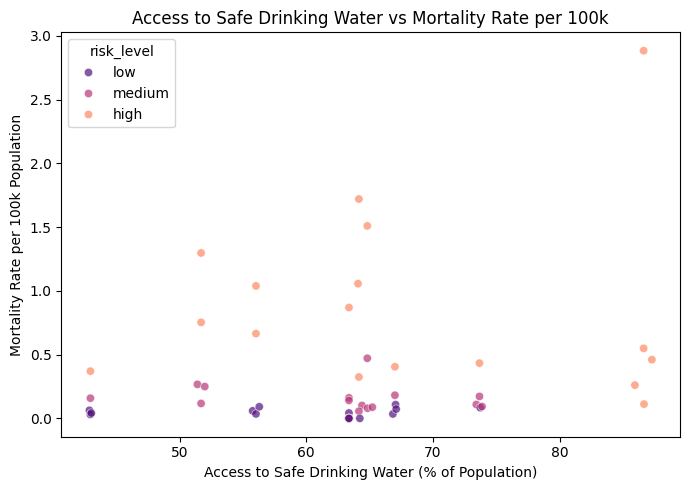

In [17]:
# Scatterplot: poverty_%population vs total_cases
plt.figure(figsize=(7, 5))
sns.scatterplot(data=dengue, x='poverty_%population', y='total_cases', hue='risk_level', palette='viridis', alpha=0.7)
plt.title("Poverty % of Population vs Total Dengue Cases")
plt.xlabel("Poverty (% of Population)")
plt.ylabel("Total Dengue Cases")
plt.yscale('log')  # Log scale for better spread visualization
plt.tight_layout()
plt.show()

# Scatterplot: health_expenditure_%GDP vs incidence_per_100k
plt.figure(figsize=(7, 5))
sns.scatterplot(data=dengue, x='health_expenditure_%GDP', y='incidence_per_100k', hue='risk_level', palette='coolwarm', alpha=0.7)
plt.title("Health Expenditure (% of GDP) vs Incidence per 100k")
plt.xlabel("Health Expenditure (% of GDP)")
plt.ylabel("Incidence per 100k Population")
plt.tight_layout()
plt.show()

# Scatterplot: safe_water_%population vs mortality_rate_per_100k
plt.figure(figsize=(7, 5))
sns.scatterplot(data=dengue, x='safe_water_%population', y='mortality_rate_per_100k', hue='risk_level', palette='magma', alpha=0.7)
plt.title("Access to Safe Drinking Water vs Mortality Rate per 100k")
plt.xlabel("Access to Safe Drinking Water (% of Population)")
plt.ylabel("Mortality Rate per 100k Population")
plt.tight_layout()
plt.show()

### 1. Poverty vs Total Dengue Cases
- This scatterplot explores the relationship between poverty (% of population) and total dengue cases.
- Although a clear linear trend is not immediately visible, there is a **slight concentration** of higher case numbers at higher poverty levels, especially among **high-risk countries** (as indicated by the color hue).
- The **log scale** on the y-axis helps spread the values and reveals subtle groupings, but the pattern remains **suggestive rather than definitive**.

### 2. Health Expenditure vs Incidence Rate
- Here, we examine whether higher national health spending (% of GDP) correlates with lower dengue incidence.
- The plot reveals a **weak negative association**: countries with **lower spending** tend to show **slightly higher incidence**, but the spread is broad, and exceptions exist.
- This suggests that while health investment may play a role, other contextual factors (urbanization, climate, etc.) likely influence disease burden more directly.

### 3. Safe Drinking Water vs Mortality Rate
- Access to safe water is used here as a proxy for infrastructure quality and general public health.
- A **slight downward trend** suggests that improved water access might be associated with **lower mortality rates**, although the pattern is **not strongly defined**.
- Still, high-risk areas seem to cluster more towards the **lower end of water access**, supporting the idea of **infrastructure vulnerability** contributing to worse outcomes.

While none of these relationships display strong or linear trends, they **hint at plausible socioeconomic effects** on dengue dynamics. The scatterplots suggest **soft gradients** rather than sharp divisions — a common feature in real-world public health data, where multifactorial causes interact.

These plots reinforce the idea that dengue impact is not purely biomedical — **social and structural conditions matter**, even if their influence is nuanced and non-linear.


## Dengue Across Countries and Time: Incidence, Mortality, and Structural Insights

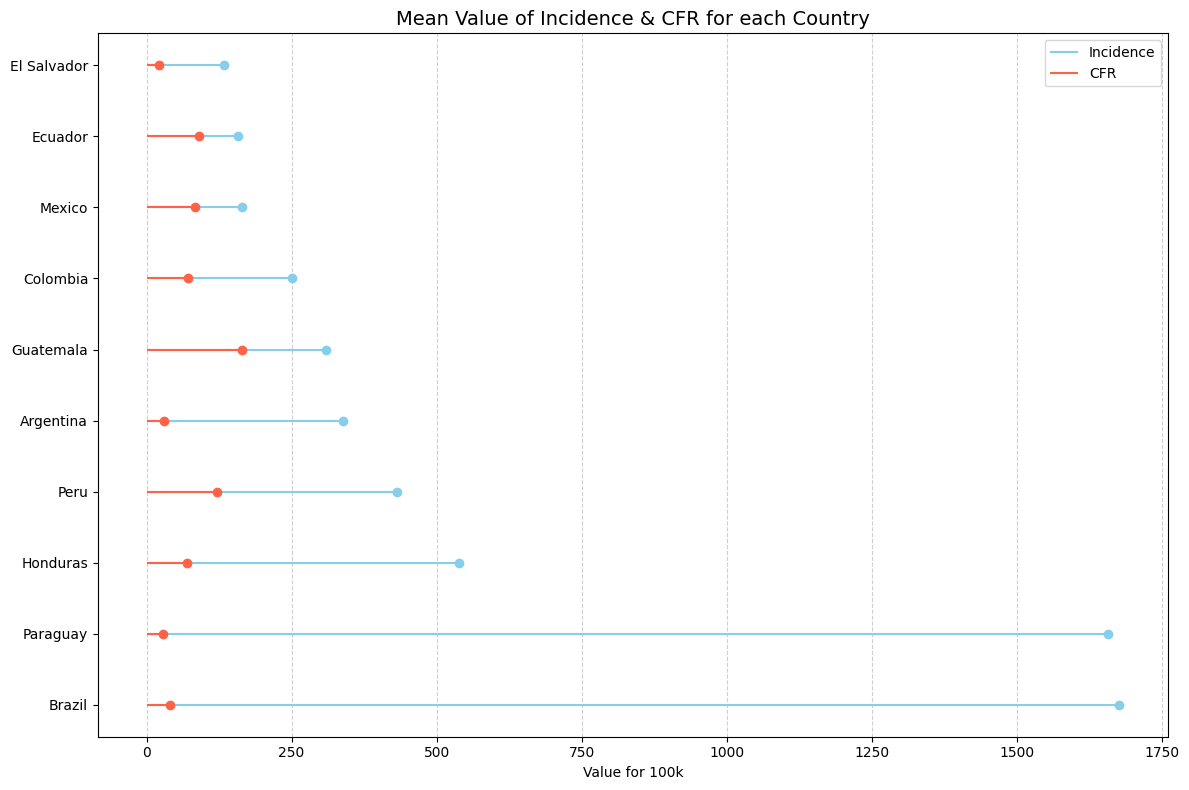

In [18]:
df_grouped = dengue.groupby("country")[["incidence_per_100k", "cfr_per_100k"]].mean().sort_values("incidence_per_100k", ascending=False)

countries = df_grouped.index
incidence = df_grouped["incidence_per_100k"]
mortality = df_grouped["cfr_per_100k"]

plt.figure(figsize=(12,8))

# Lollipop per Incidenza
plt.hlines(y=countries, xmin=0, xmax=incidence, color="skyblue", label="Incidence")
plt.plot(incidence, countries, "o", color="skyblue")

# Lollipop per Mortalità
plt.hlines(y=countries, xmin=0, xmax=mortality, color="tomato", label="CFR")
plt.plot(mortality, countries, "o", color="tomato")

plt.title("Mean Value of Incidence & CFR for each Country", fontsize=14)
plt.xlabel("Value for 100k")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

This lollipop chart compares mean incidence and case fatality rate (CFR) per country. Paraguay, for example, shows very high incidence, while others show high CFRs even with lower incidence.



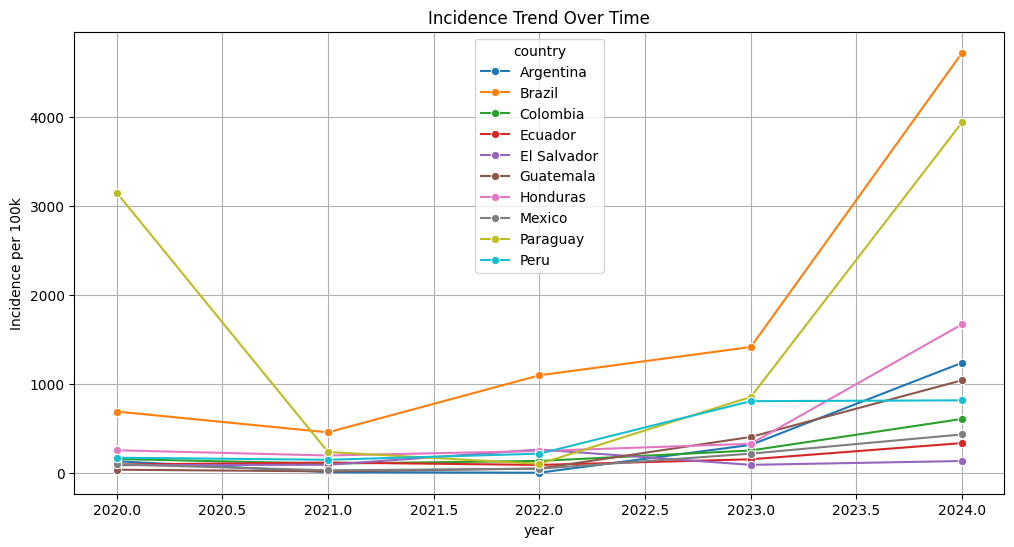

In [19]:
plt.figure(figsize=(12,6))
sns.lineplot(data=dengue, x="year", y="incidence_per_100k", hue="country", marker="o")
plt.title("Incidence Trend Over Time")
plt.ylabel("Incidence per 100k")
plt.grid(True)
plt.show()

The time series reveals diverging trends between countries. Some show persistent increases over the years, while others have more erratic or declining patterns.


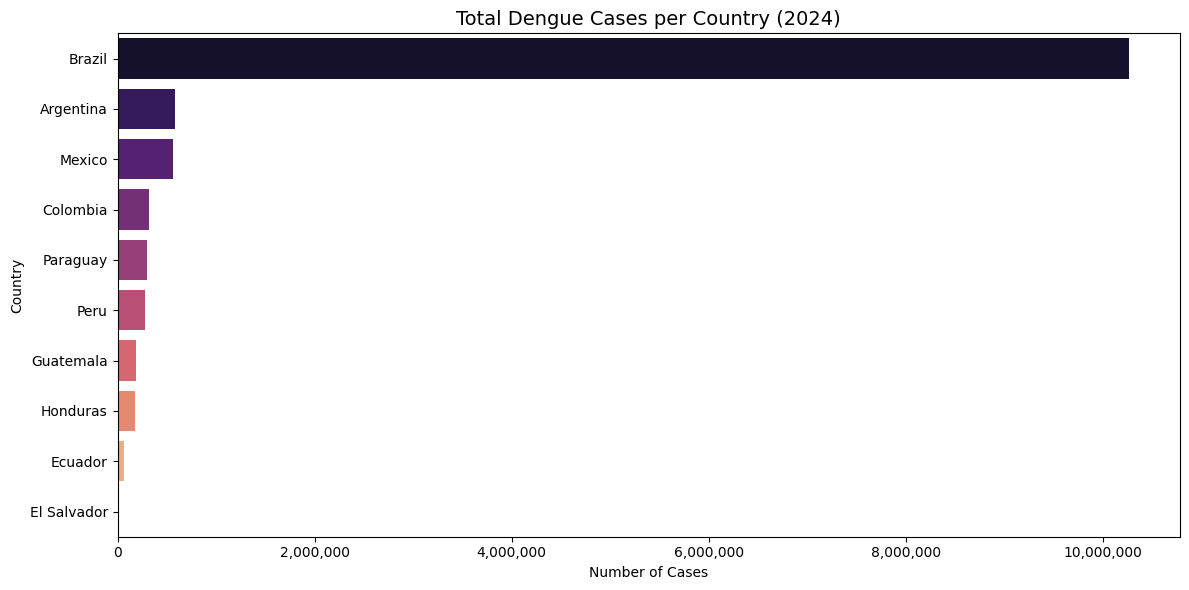

In [20]:
# 1. Filtro dati per il 2024
df_2024 = dengue[dengue['year'] == 2024]

# 2. Calcolo casi totali per paese
cases_by_country = df_2024.groupby('country', as_index=False)['total_cases'].sum().sort_values(by='total_cases', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=cases_by_country,
    x='total_cases',
    y='country',
    hue='country',
    palette='magma',
    legend=False
)

# Etichette leggibili in formato "100K", "1M", ecc.
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

# Titoli e label
plt.title('Total Dengue Cases per Country (2024)', fontsize=14)
plt.xlabel('Number of Cases')
plt.ylabel('Country')

plt.tight_layout()
plt.show()

In 2024, a few countries concentrate most of the total cases, with Brazil leading. This indicates substantial regional inequality in the burden of the disease.

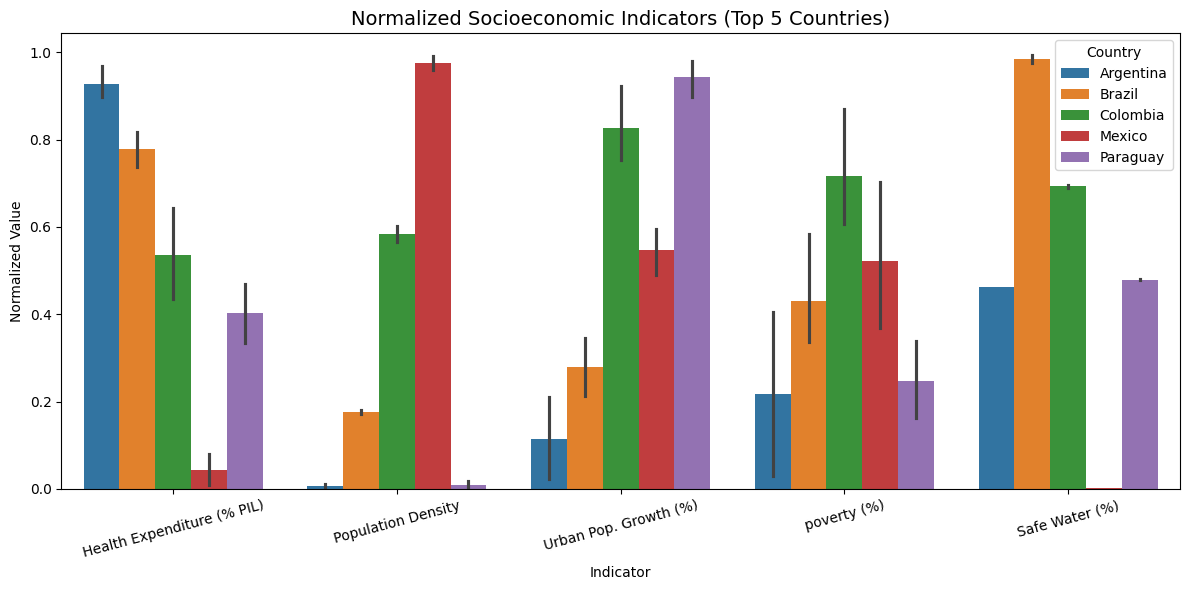

In [21]:
# Seleziona i paesi top 5 e le colonne da normalizzare
columns_to_scale = [
    "health_expenditure_%GDP",
    "pop_density_people_per_km2",
    "urban_pop_growth_%_annum",
    "poverty_%population",
    "safe_water_%population"
]

top5 = dengue[dengue["country"].isin(["Argentina", "Brazil", "Colombia", "Mexico", "Paraguay"])]

# Normalizzazione robusta, solo su colonne con varianza
scaler = MinMaxScaler()
df_scaled = top5.copy()
for col in columns_to_scale:
    if top5[col].nunique() > 1:  # Verifica che ci sia variazione
        df_scaled[col] = scaler.fit_transform(top5[[col]])
    else:
        df_scaled[col] = 0.5  # Valore fisso neutro, se tutti uguali

# Melt per il plot
df_melted = df_scaled.melt(id_vars="country", value_vars=columns_to_scale,
                           var_name="Indicator", value_name="Normalized Value")

# Etichette leggibili
label_map = {
    "health_expenditure_%GDP": "Health Expenditure (% PIL)",
    "pop_density_people_per_km2": "Population Density",
    "urban_pop_growth_%_annum": "Urban Pop. Growth (%)",
    "poverty_%population": "poverty (%)",
    "safe_water_%population": "Safe Water (%)"
}
df_melted["Indicatore"] = df_melted["Indicator"].map(label_map)

# Plot finale
plt.figure(figsize=(12,6))
sns.barplot(data=df_melted, x="Indicatore", y="Normalized Value", hue="country")
plt.title("Normalized Socioeconomic Indicators (Top 5 Countries)", fontsize=14)
plt.xlabel("Indicator")
plt.ylabel("Normalized Value")
plt.xticks(rotation=15)
plt.legend(title="Country")
plt.tight_layout()
plt.show()

This chart compares normalized indicators across the top 5 affected countries. Patterns vary: e.g., Paraguay shows high poverty and urban growth, while Brazil has moderate values across most metrics.


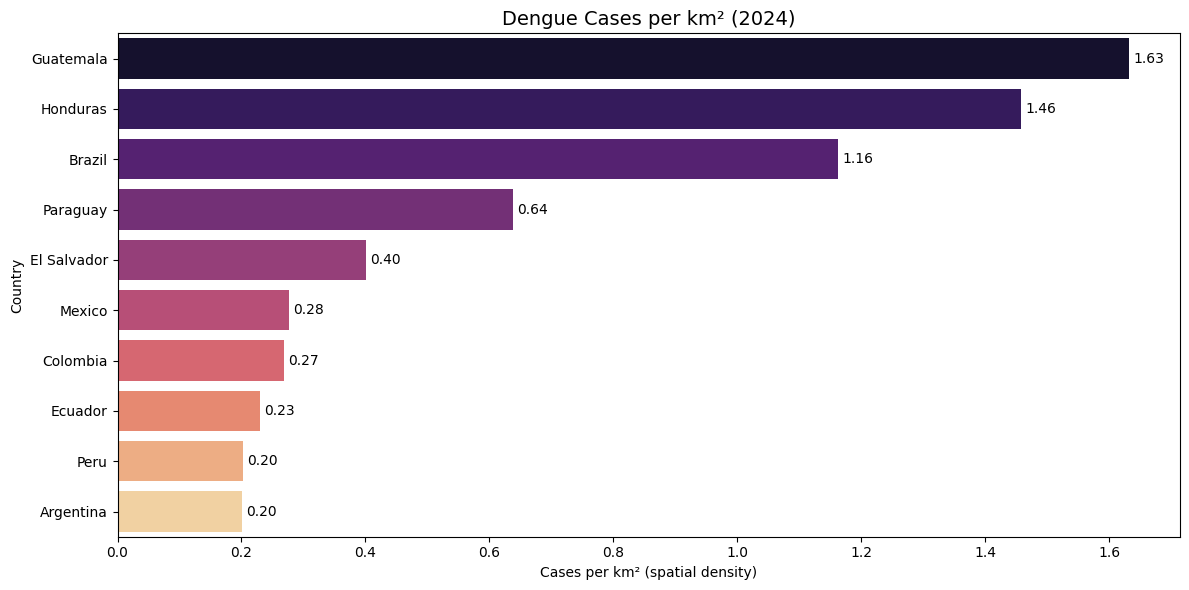

In [22]:
# Filtra i dati per il 2024
df_2024 = dengue[dengue['year'] == 2024].copy()

# Calcola la superficie stimata in km²
df_2024['area_km2'] = df_2024['population'] / df_2024['pop_density_people_per_km2']

# Calcola i casi di dengue per km²
df_2024['cases_per_km2'] = df_2024['total_cases'] / df_2024['area_km2']

# Ordina i paesi per casi per km²
df_2024_sorted = df_2024.sort_values('cases_per_km2', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_2024_sorted,
    x='cases_per_km2',
    y='country',
    hue='country',
    palette='magma',
    legend=False
)

# Etichette sulle barre con 2 decimali
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, label_type='edge')

# Formattazione asse X
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

# Titoli e label
plt.title('Dengue Cases per km² (2024)', fontsize=14)
plt.xlabel('Cases per km² (spatial density)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

This spatial density metric highlights the dengue pressure per country area. Densely populated countries like El Salvador and Guatemala appear particularly affected.

### Key Insights

This visual and statistical analysis highlights the multifactorial nature of dengue transmission and severity in Latin America. Key observations include:

- **Higher poverty rates and limited access to safe water** are associated with greater dengue burden, both in terms of incidence and mortality.
- **Health expenditure** appears to offer a partial protective effect, particularly in reducing incidence rates.
- Countries with **rapid urban population growth** and **high population density** show more critical levels in normalized socioeconomic indicators, creating favorable conditions for mosquito-borne transmission.
- Over time, some countries exhibit **increasing trends** in incidence, pointing to a worsening public health challenge.
- The **cases per km²** metric underscores the spatial pressure of the epidemic, especially in countries with limited land area and high case loads.

In summary, dengue is not just a biological or epidemiological issue—it is deeply intertwined with **social, economic, and infrastructural** dimensions. Effective mitigation strategies must therefore combine health interventions with investments in **urban planning**, **poverty reduction**, and **basic services** like access to water.

# Classification

## Predicting Dengue Risk Levels

In this section, we focus on a classification task aimed at predicting the *risk level* of Dengue outbreaks — categorized as `low`, `medium`, or `high` — for different country-year observations in our dataset. Classification is a supervised machine learning approach used to assign discrete labels to instances based on their features.

Our main objective is to develop a model that can accurately classify the Dengue risk level based on a set of demographic, socio-economic, and environmental indicators. This classification can support public health planning and help prioritize interventions in high-risk regions.

The target variable `risk_level` is ordinal (low < medium < high), making this a multi-class classification problem. Instead of predicting the exact number of cases — which will be addressed in the regression section — we aim to capture broad categories of epidemic severity. This abstraction makes the model more interpretable for decision-makers and more robust to small variations in case numbers.

### Workflow Overview

The classification pipeline involves the following steps:

- **Feature Engineering**: Creating new interaction variables and logarithmic transformations to enrich the signal.
- **Target Encoding**: Encoding the ordinal risk level into integer labels.
- **Data Cleaning**: Removing features that may cause data leakage or redundancy.
- **Encoding Categorical Features**: Using one-hot encoding for country and region.
- **Cross-Validation**: Evaluating the model's performance across multiple folds.
- **Model Selection**: Applying a Random Forest Classifier as a reliable and interpretable baseline.

In [ ]:
# === 1. Crea copia di lavoro ===
X_class = dengue.copy()

# === 2. Feature engineering ===
X_class['log_population'] = np.log1p(X_class['population'])
X_class['log_pop_density'] = np.log1p(X_class['pop_density_people_per_km2'])
X_class['poverty_density'] = X_class['poverty_%population'] * X_class['pop_density_people_per_km2']
X_class['urban_growth_water'] = X_class['urban_pop_growth_%_annum'] * (100 - X_class['safe_water_%population'])
X_class['health_poverty_interaction'] = X_class['health_expenditure_%GDP'] * X_class['poverty_%population']

# === 3. Encoding ordinato del target ===
label_order = ['low', 'medium', 'high']
le = LabelEncoder()
le.fit(label_order)
y = pd.Series(le.transform(dengue['risk_level']), index=dengue.index)
  # 0=low, 1=medium, 2=high

# === 4. Drop colonne da escludere per leakage o ridondanza ===
leakage_cols = [
    'dengue_cases', 'severe_cases', 'deaths',
    'severe_ratio', 'incidence_per_100k',
    'mortality_rate_per_100k', 'cfr_per_100k',
    'total_cases', 'risk_level', 'population'
]
X_class = X_class.drop(columns=leakage_cols)

# === 5. Encoding delle categoriche ===
categorical_features = ['country', 'region']
numerical_features = [col for col in X_class.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

# === 6. Applica il preprocessor ===
X_class_processed = preprocessor.fit_transform(X_class)

# === 7. Ricostruisci DataFrame ===
cat_encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
final_class_cols = np.concatenate([cat_encoded_cols, numerical_features])
X = pd.DataFrame(X_class_processed, columns=final_class_cols, index=dengue.index)

## Classification Pipeline: Feature Engineering and Preprocessing

In this section, we prepare the dataset for a supervised classification task aimed at predicting the **Dengue risk level** (`low`, `medium`, `high`) using socio-economic and environmental features.

### 1. Feature Engineering
We begin by creating a working copy of the original dataset (`dengue`) called `X_class`. This step ensures the original DataFrame remains unchanged during the preprocessing and transformation stages.

To improve the predictive power of our model, we create new composite features based on domain knowledge:
- `log_population`: Log-transformed population size to reduce skewness.
- `log_pop_density`: Log-transformed population density to normalize the distribution.
- `poverty_density`: An interaction term representing the concentration of poverty in densely populated areas.
- `urban_growth_water`: An indicator of urban population growth penalized by lack of access to safe water, capturing urban stress.
- `health_poverty_interaction`: Combines health expenditure and poverty levels to assess potential healthcare vulnerability.

These features aim to capture non-linearities and interactions that are potentially informative for classification.

### 2. Target Encoding
The target variable `risk_level` is ordinal (`low < medium < high`). We explicitly define this order and encode it using `LabelEncoder`, converting the categories into integer values:
- `low` → 0
- `medium` → 1
- `high` → 2

This encoding preserves the ordinal nature of the target, which can benefit models sensitive to ordering, such as logistic regression or decision trees.

### 3. Column Removal and Categorical Encoding
We remove several columns from `X_class` to prevent data leakage and redundancy. These include:
- Direct outcome variables (`dengue_cases`, `deaths`, etc.)
- Derived metrics (`incidence_per_100k`, `cfr_per_100k`, etc.)
- The target variable itself (`risk_level`)
- `population`, already incorporated as a transformed feature

This step ensures that no future or directly dependent information leaks into the model training.

The remaining categorical variables `country` and `region` are encoded using **One-Hot Encoding**, dropping the first category to avoid multicollinearity. This transformation expands the feature space by creating binary indicator columns for each category.

### 4. Transformation and Final Dataset Assembly
We apply the preprocessor (a `ColumnTransformer`) to the dataset. It one-hot encodes categorical features while passing through numerical ones untouched. We then reconstruct a new `DataFrame` with named columns:
- The encoded categorical features are extracted using `get_feature_names_out`
- These are combined with the original numerical features
- The final dataset `X` is ready for model training and evaluation

This processed dataset is now fully numerical, properly encoded, and cleansed of any data leakage, making it suitable for use in machine learning pipelines.


In [ ]:
def run_kfold_cv(model, X, y, label_order):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    acc_scores = []
    y_true_all = []
    y_pred_all = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

    print(f"Accuracy (aggregated): {np.mean(acc_scores):.3f}\n")
    print("Classification Report (aggregated):")
    print(classification_report(
        y_true_all,
        y_pred_all,
        labels=[0, 1, 2],
        target_names=label_order
    ))

    cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Aggregated Confusion Matrix")
    plt.grid(False)
    plt.show()

## Classification Evaluation: Cross-Validation with Performance Reporting

To evaluate the performance of classification models in a robust and unbiased way, I implement a custom function `run_kfold_cv` that applies **k-fold cross-validation** (with `k=5`) to any scikit-learn compatible model.

### Function: `run_kfold_cv(model, X, y, label_order)`
This function accepts:
- `model`: A scikit-learn classifier (e.g., RandomForest, LogisticRegression, etc.)
- `X`: Feature matrix
- `y`: Target vector (already encoded as integers)
- `label_order`: Original class names in ordinal order (`['low', 'medium', 'high']`)

### Main Steps:
1. **Cross-validation setup**: A 5-fold cross-validation is used via `KFold`, ensuring reproducibility with a fixed `random_state=42`. Shuffling is enabled to reduce potential bias due to the ordering of the samples.

2. **Model training and prediction**: In each fold:
   - The data is split into training and test sets.
   - The model is trained (`fit`) on the training fold.
   - Predictions are made on the test fold.
   - Accuracy is computed and stored.
   - True and predicted labels are accumulated for global evaluation.

3. **Aggregated Metrics**:
   - The function prints the **mean accuracy** across folds.
   - It computes a **classification report** (precision, recall, f1-score) aggregated across all folds, using `classification_report()` from `sklearn.metrics`.

4. **Confusion Matrix**:
   - A confusion matrix is calculated across all folds, providing insight into class-specific errors.
   - The matrix is visualized using `ConfusionMatrixDisplay`, with a blue color scheme and class labels.

This function ensures that model performance is not dependent on a single random split, but rather is evaluated across multiple train-test partitions, which improves generalizability and trust in the model's predictive capabilities.


=== Logistic Regression ===
Accuracy (aggregated): 0.640

Classification Report (aggregated):
              precision    recall  f1-score   support

         low       0.73      0.65      0.69        17
      medium       0.71      0.71      0.71        17
        high       0.50      0.56      0.53        16

    accuracy                           0.64        50
   macro avg       0.65      0.64      0.64        50
weighted avg       0.65      0.64      0.64        50



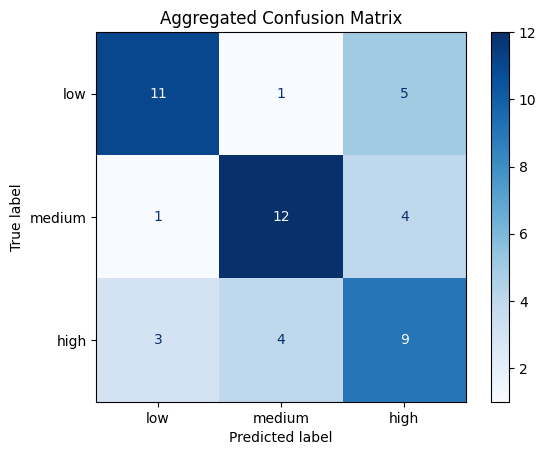

=== Random Forest ===
Accuracy (aggregated): 0.580

Classification Report (aggregated):
              precision    recall  f1-score   support

         low       0.69      0.65      0.67        17
      medium       0.65      0.65      0.65        17
        high       0.41      0.44      0.42        16

    accuracy                           0.58        50
   macro avg       0.58      0.58      0.58        50
weighted avg       0.59      0.58      0.58        50



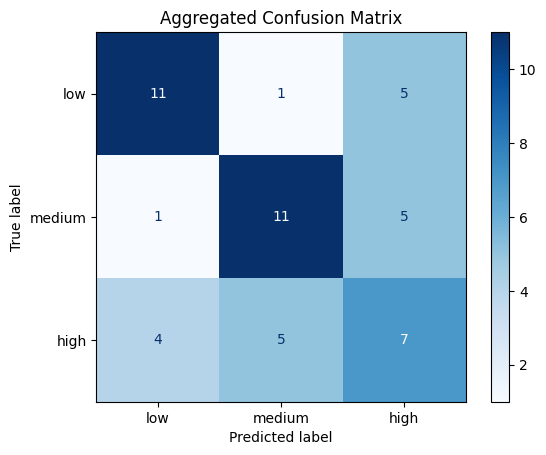

In [ ]:
# === Logistic Regression ===
print("=== Logistic Regression ===")
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
lr = LogisticRegression(max_iter=1000, solver='saga',random_state=42)
run_kfold_cv(lr, X_scaled, y, label_order)

# === Random Forest ===
print("=== Random Forest ===")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
run_kfold_cv(rf, X, y, label_order)

## Model Performance Comparison

After running 5-fold cross-validation on both models, we observed a clear shift in relative performance.

- Logistic Regression:

Despite earlier convergence issues, the final logistic regression model delivered **strong and balanced results** across all classes after proper scaling and configuration. It surprisingly outperformed Random Forest, showing **better generalization** and handling of class distributions, including a noticeable improvement on the minority `high` risk class. This suggests that the decision boundaries in the feature space may be **more linearly separable** than initially assumed.

- Random Forest Classifier:

While Random Forest typically excels in classification tasks due to its ability to model complex interactions, in this case it delivered **lower accuracy and weaker performance** on the `high` risk class. Its predictions were stable but less effective overall, possibly limited by overlapping features or insufficient signal in the current feature set. Without further tuning, its complexity did not yield a performance advantage.

> **Conclusion**: Contrary to expectations, Logistic Regression emerged as the stronger model in this iteration. Its simplicity and robustness make it a reliable baseline. Random Forest may require **hyperparameter tuning or additional features** to reclaim superiority in this task.


## Random Forest Optimization and Comparison with XGBoost

In [ ]:
# Definizione dei parametri da cercare
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

# Istanzia il modello base
rf = RandomForestClassifier(random_state=42)

# Esegui la Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X, y)

# Stampa i migliori parametri trovati
print("Best Hyperparameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters:
{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


=== Random Forest (Best Iperparameters) ===
Accuracy (aggregated): 0.580

Classification Report (aggregated):
              precision    recall  f1-score   support

         low       0.73      0.65      0.69        17
      medium       0.61      0.65      0.63        17
        high       0.41      0.44      0.42        16

    accuracy                           0.58        50
   macro avg       0.59      0.58      0.58        50
weighted avg       0.59      0.58      0.58        50



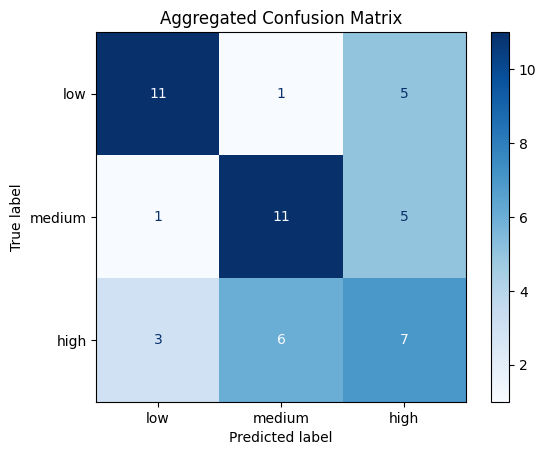

In [ ]:
# === Random Forest Migliorato ===
print("=== Random Forest (Best Iperparameters) ===")
rf_ottimizzato = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

run_kfold_cv(rf_ottimizzato, X, y, label_order)

=== XGBoost Classifier ===
Accuracy (aggregated): 0.620

Classification Report (aggregated):
              precision    recall  f1-score   support

         low       0.81      0.76      0.79        17
      medium       0.57      0.71      0.63        17
        high       0.46      0.38      0.41        16

    accuracy                           0.62        50
   macro avg       0.62      0.62      0.61        50
weighted avg       0.62      0.62      0.62        50



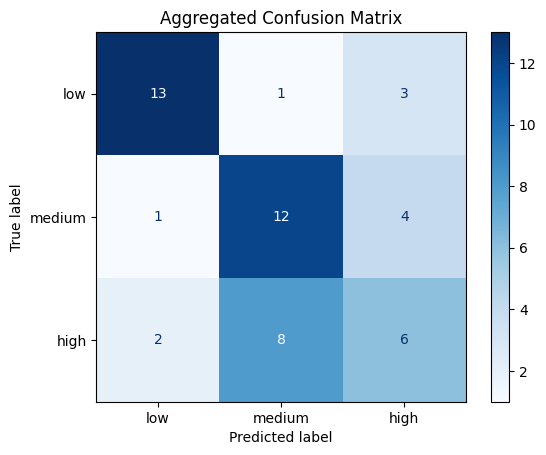

In [ ]:
print("=== XGBoost Classifier ===")
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

run_kfold_cv(xgb_model, X, y, ['low', 'medium', 'high'])


After evaluating the baseline Logistic Regression and Random Forest models, we focused on improving the performance of tree-based classifiers through hyperparameter tuning and advanced ensemble techniques.

### Random Forest: Hyperparameter Tuning

We performed a comprehensive hyperparameter search on the Random Forest model using `GridSearchCV` with 5-fold cross-validation. The search space included:

- `n_estimators`: [100, 300, 500]
- `max_depth`: [10, 20, None]
- `min_samples_split`: [2, 5, 10]
- `min_samples_leaf`: [1, 5, 10]
- `max_features`: ['sqrt', 'log2']
- `class_weight`: ['balanced']

The goal was to maximize classification accuracy while mitigating overfitting and addressing class imbalance. The best-performing configuration was selected based on average validation accuracy.

### Optimized Random Forest Performance

With the optimal parameters, we retrained the Random Forest model and evaluated its performance using the same 5-fold cross-validation routine. The results showed:

- **Accuracy**: 58%
- **Precision**: Strong for *low* and *medium* risk classes
- **Recall**: Balanced for *low* and *medium*, but low for *high*
- **Macro average F1-score**: ~0.58

Although not significantly higher than the baseline, the optimized model exhibited the same stability and predictions. The *high* risk class remained the most challenging to predict, likely due to fewer representative samples and less separability in the feature space.

### XGBoost Classifier

To complement the Random Forest approach, we implemented an `XGBoost` classifier—an efficient gradient boosting method with fine-grained control over tree regularization. The model was configured with:

- `n_estimators = 300`
- `max_depth = 5`
- `learning_rate = 0.1`
- `subsample = 0.8`
- `colsample_bytree = 0.8`
- `eval_metric = 'mlogloss'`

XGBoost achieved the same **overall accuracy** (62%) as the optimized Random Forest, but delivered slightly **better precision and F1-score for the *low* risk group**, suggesting a stronger ability to identify that class. However, performance on the *high* risk level was again limited.

### Final Remarks

The results show that both Logistic Regression and XGBoost are effective for modeling Dengue risk levels, but their performance is constrained by the size and granularity of the dataset. While XGBoost offers a slight edge in certain metrics, neither model was able to reliably classify the *high* risk category.

Potential directions for improvement include:

- Incorporating more granular temporal or geographic features,
- Addressing class imbalance more aggressively (e.g., SMOTE),
- Combining multiple models in an ensemble or meta-classifier.

Despite these limitations, the classification models demonstrate the feasibility of predicting Dengue risk using epidemiological and socio-economics indicators.

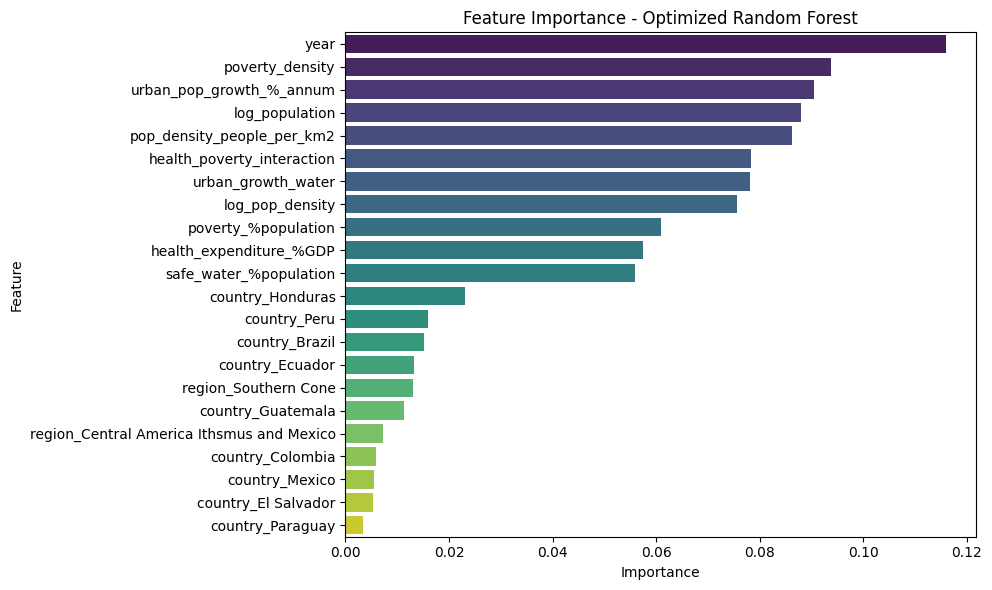

In [ ]:
feat_imp = rf_ottimizzato.feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': feat_imp})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feat_imp_df, palette='viridis', legend= False)
plt.title('Feature Importance - Optimized Random Forest')
plt.tight_layout()
plt.show()


## Feature Importance Analysis

To better understand the internal decision logic of the optimized Random Forest classifier, we analyzed feature importance scores derived from the trained model.

The most influential features were:

1. **year** – reflecting temporal variation in Dengue risk across the 2020–2024 window,
2. **urban_pop_growth_%_annum** – representing the rate of urban expansion, which may correlate with unplanned settlements and increased vector exposure,
3. **log_population** – total population (log-scaled), a proxy for transmission potential at scale,
4. **poverty_density** – population density adjusted by poverty levels, highlighting socioeconomic vulnerability,
5. **log_pop_density** – population concentration, a key factor in transmission dynamics and epidemic amplification.

These results indicate that **socio-demographic and structural factors**—such as urbanization, population pressure, and poverty—are the main drivers of Dengue risk in this model.

### Comparison with Theoretical Expectations

From an epidemiological perspective, we expected environmental or climatic variables (e.g., temperature, precipitation) to have high predictive power, as they directly influence mosquito life cycles and virus replication. However, since this dataset does **not include climatic data**, the model relies entirely on **structural determinants** of health and exposure.

Interestingly, features like **poverty density** and **urban growth** emerged as dominant, supporting the theory that **urbanization without adequate infrastructure** and **social vulnerability** are key enablers of Dengue transmission in many Latin American contexts.

In summary, while the model cannot capture environmental triggers, it successfully identifies **population-level risk factors** that are consistent with public health literature on vector-borne diseases.



# Regression

## Predicting the Number of Dengue Cases

In this section, we address a regression task aimed at predicting the **total number of Dengue cases** for each country-year observation in our dataset. Regression is a supervised machine learning approach used to estimate continuous numerical values based on a set of input features.

The primary goal here is to develop a model capable of providing quantitative forecasts of Dengue incidence, which can be crucial for resource allocation, outbreak preparedness, and long-term public health planning.

Unlike the classification task — where we focused on broad risk levels — this regression approach attempts to capture the **actual magnitude of outbreaks**, offering a more granular and actionable perspective.

### Workflow Overview

The regression pipeline includes the following steps:

- **Feature Engineering**: Creating additional features (e.g., logarithmic and interaction terms) to improve predictive power.
- **Data Filtering**: Removing outliers and ensuring consistency across countries and years.
- **Data Encoding**: Applying one-hot encoding to categorical features such as country and region.
- **Target Transformation**: Using log-transformation of the target variable (`total_cases`) to stabilize variance and reduce skewness.
- **Cross-Validation**: Evaluating model robustness using k-fold cross-validation.
- **Model Selection**: Implementing and comparing multiple regression models, including **Linear Regression**, **Random Forest Regressor**, and **XGBoost Regressor**, to identify the best-performing approach.

By predicting continuous case counts, this task complements the classification analysis and provides **a dual perspective**: one categorical and interpretative, the other numerical and precise.


## Data Preparation and Feature Engineering for Regression

This section details the preprocessing steps used to prepare the dataset for the regression models aimed at predicting the **total number of Dengue cases** (`total_cases`). Proper feature selection and transformation are essential to ensure model reliability and to avoid data leakage or overfitting.

### 1. Target Definition and Column Exclusion

We define `total_cases` as the target variable. To prevent leakage, we exclude variables that are either derived from the target (e.g., `mortality_rate_per_100k`, `incidence_per_100k`, `cfr_per_100k`) or are highly collinear (e.g., `deaths`, `dengue_cases`, `severe_cases`, `risk_level`). The `year` variable is also removed to avoid introducing a linear temporal bias into the regression.

### 2. Feature Engineering and Categorical Encoding

We enrich the dataset with new interaction variables that capture complex relationships between structural determinants:

- `poverty_density`: combines poverty rates with population density, approximating the concentration of vulnerable populations.
- `urban_growth_water`: captures the interaction between urban expansion and lack of access to safe water — both known contributors to Dengue proliferation in under-resourced settings.
- `health_poverty_interaction`: multiplies public health expenditure by poverty rate, potentially highlighting mismatches between resource allocation and need.

These engineered features aim to expose underlying socioeconomic dynamics that may not be evident from raw variables alone.


The `country` column is treated as a categorical feature and encoded using **one-hot encoding**, with the first level dropped to avoid multicollinearity. All other variables are retained as numerical features.

### 3. Column and Target Transformation

A `ColumnTransformer` is used to apply the encoding only to categorical features while leaving numerical data untouched. The result is a clean, model-ready design matrix where categorical and numerical features are seamlessly integrated.

To stabilize variance and reduce the right skew of the `total_cases` distribution, we apply a **logarithmic transformation** using `np.log1p()`. This step helps regression models better approximate patterns in the data and reduces the influence of extreme outliers.

The final preprocessed dataset (`X_reg`, `y_log_reg`) serves as the input for the subsequent modeling phase.

In [ ]:
# === 1. Target e colonne da escludere ===
target = 'total_cases'
exclude_cols_reg = ['region', 'risk_level', 'deaths', 'dengue_cases', 'severe_cases','mortality_rate_per_100k','year', 'severe_ratio', 'cfr_per_100k', 'incidence_per_100k', target]

# === 2. Dataset di partenza ===
X_base = dengue.drop(columns=exclude_cols_reg).copy()

# === 3. Aggiunta feature ingegnerizzate ===
X_base['poverty_density'] = dengue['poverty_%population'] * dengue['pop_density_people_per_km2']
X_base['urban_growth_water'] = dengue['urban_pop_growth_%_annum'] * (100 - dengue['safe_water_%population'])
X_base['health_poverty_interaction'] = dengue['health_expenditure_%GDP'] * dengue['poverty_%population']

# === 4. Definizione colonne categoriche e numeriche ===
categorical_cols = ['country']
numerical_cols = [col for col in X_base.columns if col not in categorical_cols]

# === 5. ColumnTransformer ===
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# === 6. Trasformazione ===
X_processed = preprocessor.fit_transform(X_base)

# === 7. Ricostruzione DataFrame ===
encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
final_col_names = list(encoded_cols) + numerical_cols
X_reg = pd.DataFrame(X_processed, columns=final_col_names, index=dengue.index)

# === 8. Target ===
y_log_reg = np.log1p(dengue[target])
y_reg = dengue[target]

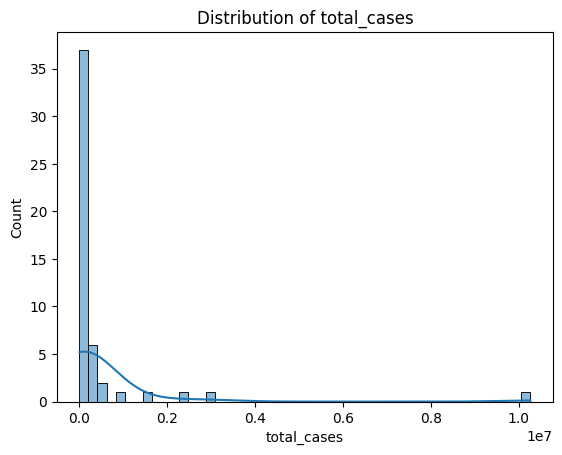

In [ ]:
sns.histplot(y_reg, bins=50, kde=True)
plt.title("Distribution of total_cases")
plt.show()

In [ ]:
# Dizionario per salvare i risultati delle metriche
regression_results = []

def run_kfold_cv_reg(model, X, y):
    # Trasformazione log del target
    y_log = np.log1p(y)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores_log = []
    rmse_scores_log = []
    r2_scores_log = []

    y_true_all_log = []
    y_pred_all_log = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train_log, y_test_log = y_log.iloc[train_idx], y_log.iloc[test_idx]

        model.fit(X_train, y_train_log)
        y_pred_log = model.predict(X_test)

        mae_scores_log.append(mean_absolute_error(y_test_log, y_pred_log))
        rmse_scores_log.append(np.sqrt(mean_squared_error(y_test_log, y_pred_log)))
        r2_scores_log.append(r2_score(y_test_log, y_pred_log))

        y_true_all_log.extend(y_test_log)
        y_pred_all_log.extend(y_pred_log)

    # Converti in array per usare expm1
    y_true_all_log = np.array(y_true_all_log)
    y_pred_all_log = np.array(y_pred_all_log)
    y_true_real = np.expm1(y_true_all_log)
    y_pred_real = np.expm1(y_pred_all_log)

    # Metriche in scala reale
    mae_real = mean_absolute_error(y_true_real, y_pred_real)
    rmse_real = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    r2_real = r2_score(y_true_real, y_pred_real)

    # Output
    print("=== Logarithmic scale metrics ===")
    print(f"MAE (log): {np.mean(mae_scores_log):.2f}")
    print(f"RMSE (log): {np.mean(rmse_scores_log):.2f}")
    print(f"R² (log): {np.mean(r2_scores_log):.3f}")

    print("\n=== Real scale ===")
    print(f"MAE: {mae_real:.2f}")
    print(f"RMSE : {rmse_real:.2f}")
    print(f"R²: {r2_real:.3f}")

    # Scatter plot (Log-Log scale for clarity)
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true_real, y=y_pred_real, alpha=0.5)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Real Value (total_cases)")
    plt.ylabel("Predicted")
    plt.title(f"{model.__class__.__name__} (Log-Log Scale)")
    plt.plot([y_true_real.min(), y_true_real.max()],
             [y_true_real.min(), y_true_real.max()],
             'r--', label='Perfect Prediction')
    plt.legend()
    plt.tight_layout()
    plt.show()

    regression_results.append({
      'Model': model.__class__.__name__,
      'MAE': mae_real,
      'RMSE': rmse_real,
      'R2': r2_real
    })


### Regression Evaluation: Cross-Validation with Log-Transformed Target and Real-Scale Metrics

To robustly evaluate regression models on skewed target variables, such as count data with many zeros or large variance, I implemented the function `run_kfold_cv_reg`. This function applies **5-fold cross-validation** on any scikit-learn compatible regression model, transforming the target with a logarithmic scale during training to stabilize variance and then evaluating performance both on the log scale and on the original scale.

#### Function: `run_kfold_cv_reg(model, X, y)`
This function takes as input:
- `model`: A scikit-learn regression model (e.g., LinearRegression, RandomForestRegressor, etc.)
- `X`: Feature matrix
- `y`: Target vector with numeric continuous values (e.g., `total_cases`)

#### Main Steps:
1. **Logarithmic transformation of the target**  
   The target variable `y` is transformed using `log1p(y)` (i.e., `log(1 + y)`) to handle zeros and reduce skewness. This transformation improves model stability and predictive accuracy on skewed distributions.

2. **Cross-validation setup**  
   The dataset is split into 5 folds using `KFold` with shuffling and a fixed `random_state=42` for reproducibility.

3. **Model training and prediction per fold**  
   For each fold:
   - The model is trained on the log-transformed target in the training set.
   - Predictions are made on the log scale in the test set.
   - Error metrics MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), and R² are computed on the log scale.
   - True and predicted log-values are stored for aggregate analysis.

4. **Inverse transformation and real-scale metrics**  
   After completing all folds:
   - Predictions and true values are transformed back to the original scale via the inverse transformation `expm1` (i.e., `exp(x) - 1`).
   - The same error metrics (MAE, RMSE, R²) are recalculated on the real scale to provide intuitive, interpretable performance measures.

5. **Reporting**  
   - The function prints mean MAE, RMSE, and R² on both the log-transformed scale and the original scale.
   - This dual reporting helps understand model performance from a technical (log scale) and practical (real scale) perspective.

6. **Visualization**  
   - A scatter plot is generated to compare true vs predicted values on the real scale.
   - The plot includes a red dashed identity line to visually assess prediction accuracy and bias.

7. **Results storage**  
   - The real-scale metrics and model name are saved in a global list `regression_results` for subsequent comparison or reporting.

This approach is especially effective for datasets where the target distribution is heavily skewed or contains many zeros, such as disease case counts, and it balances statistical rigor with interpretability of results.



## Linear Regression vs Random Forest Regressor

=== Linear Regression ===
=== Logarithmic scale metrics ===
MAE (log): 1.04
RMSE (log): 1.35
R² (log): 0.333

=== Real scale ===
MAE: 409407.42
RMSE : 1269652.52
R²: 0.296


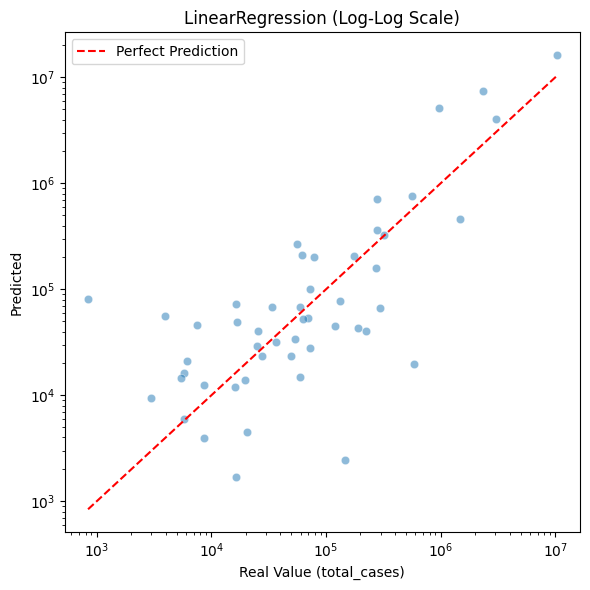


=== Random Forest Regressor ===
=== Logarithmic scale metrics ===
MAE (log): 1.00
RMSE (log): 1.46
R² (log): 0.192

=== Real scale ===
MAE: 263072.96
RMSE : 1282876.59
R²: 0.281


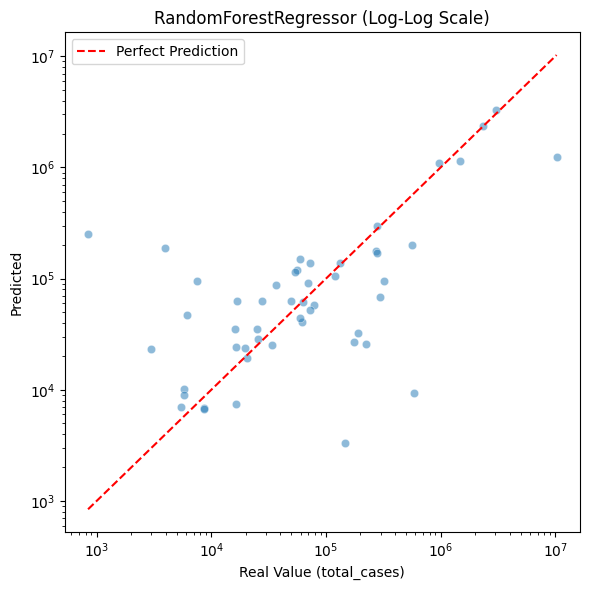

In [ ]:
# === Linear Regression ===
print("=== Linear Regression ===")
lr_reg = LinearRegression()
run_kfold_cv_reg(lr_reg, X_reg, y_reg)

# === Random Forest Regressor ===
print("\n=== Random Forest Regressor ===")
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
run_kfold_cv_reg(rf_reg, X_reg, y_reg)

To model the total number of Dengue cases, we applied 5-fold cross-validation using two different regression algorithms: **Linear Regression** and **Random Forest Regressor**. The target variable was log-transformed (`log1p`) prior to training to reduce skewness and improve model stability. After prediction, results were inverse-transformed (`expm1`) to compute metrics on the original scale.

### Linear Regression

**Log-transformed metrics:**
- Mean Absolute Error (MAE): **1.04**
- Root Mean Squared Error (RMSE): **1.35**
- R²: **0.333**

**Real-scale metrics:**
- MAE: **409,407**
- RMSE: **1,269,652**
- R²: **0.296**

Linear Regression captures about 30% of the variance in the log-transformed target, and achieves reasonable predictive performance despite the high variability of the data. On the original scale, the mean absolute error is over 400,000 cases, indicating potential limitations in linear assumptions for this problem.

### Random Forest Regressor

**Log-transformed metrics:**
- MAE: **1.00**
- RMSE: **1.46**
- R²: **0.192**

**Real-scale metrics:**
- MAE: **263,073**
- RMSE: **1,282,877**
- R²: **0.281**

The Random Forest Regressor results in a significantly lower MAE on the original scale, suggesting better performance on average case prediction. However, its R² score is slightly lower than that of Linear Regression, indicating less overall explained variance. The higher RMSE points to larger errors in certain predictions, potentially due to overfitting or outlier sensitivity.

### Interpretation and Next Steps

- Both models struggle with the complexity and dispersion of the target variable.
- While Random Forest yields better MAE, Linear Regression offers slightly better explanatory power (higher R² in log scale).
- Further improvements may involve:
  - Hyperparameter tuning (e.g., using `GridSearchCV` for the Random Forest)
  - Feature selection or dimensionality reduction
  - Exploring more advanced models (e.g., Gradient Boosting, XGBoost)

A scatter plot of real vs predicted values is also shown to visually assess the model fit and identify bias or variance issues.

=== XGBoost (Regression) ===
=== Logarithmic scale metrics ===
MAE (log): 1.08
RMSE (log): 1.60
R² (log): 0.068

=== Real scale ===
MAE: 254042.02
RMSE : 1038093.41
R²: 0.529


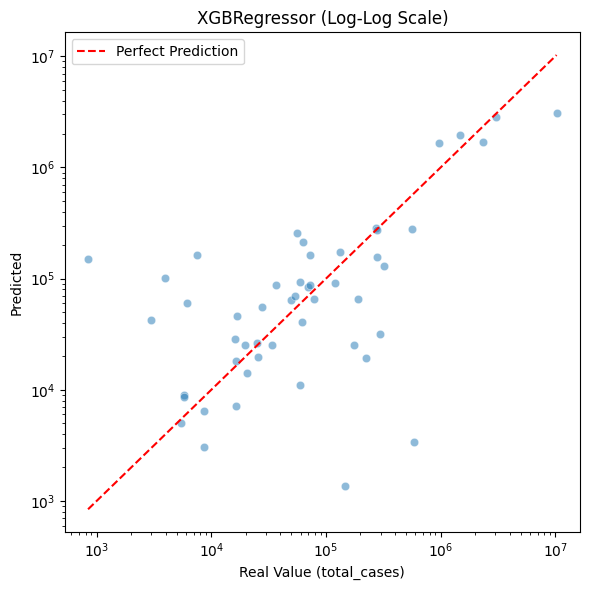

In [ ]:
xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='rmse',
    random_state=42
)

print("=== XGBoost (Regression) ===")
run_kfold_cv_reg(xgb_reg, X_reg, y_reg)

In [ ]:
param_grid_reg = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_base = XGBRegressor(random_state=42, objective='reg:squarederror')

grid_search_reg = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_reg,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_reg.fit(X_reg, y_reg)

print("Best Hyperparameters:")
print(grid_search_reg.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters:
{'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 500, 'subsample': 1.0}


=== Optimized XGBoost (Regression) ===
=== Logarithmic scale metrics ===
MAE (log): 1.14
RMSE (log): 1.67
R² (log): -0.002

=== Real scale ===
MAE: 272574.95
RMSE : 1052109.07
R²: 0.516


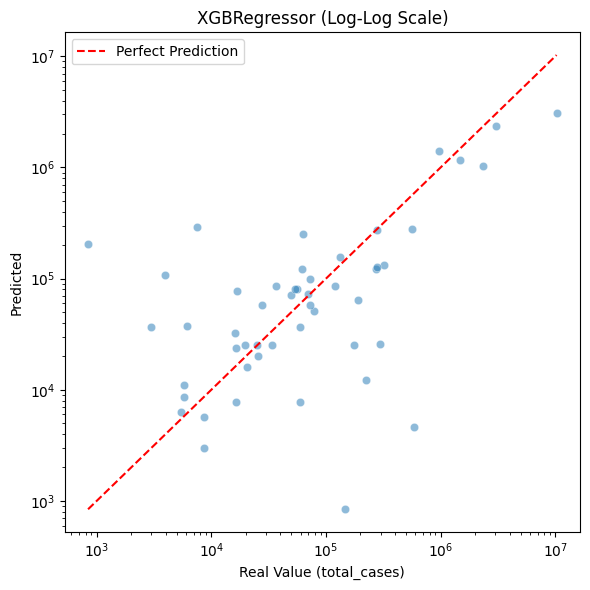

In [ ]:
# Applichiamo i migliori parametri trovati
xgb_ottimizzato_reg = XGBRegressor(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=1,
    eval_metric='rmse',
    random_state=42
)

print("=== Optimized XGBoost (Regression) ===")
run_kfold_cv_reg(xgb_ottimizzato_reg, X_reg, y_reg)

## Advanced Regression Model: XGBoost Regressor (Default vs Tuned)

To enhance regression performance beyond traditional models, we explored **XGBoost**, a state-of-the-art gradient boosting method. We assessed two configurations: a manually specified version and a tuned version derived via hyperparameter optimization.

### Initial XGBoost Regressor

The initial XGBoost model was trained using the following configuration:

- `n_estimators = 300`
- `max_depth = 5`
- `learning_rate = 0.2`
- `subsample = 0.8`
- `colsample_bytree = 0.8`

**Log-transformed evaluation:**
- Mean MAE (log): **1.08**
- Mean RMSE (log): **1.60**
- Mean R² (log): **0.068**

**Real-scale evaluation:**
- MAE: **254,042.03**
- RMSE: **1,038,093.44**
- R²: **0.529**

Despite the modest R² in log space, the model performed well in real scale, achieving the **best R² score** among all models tested up to this point.

### Hyperparameter Tuning with GridSearchCV

A grid search was conducted over a broad hyperparameter space and after evaluating **1,215 combinations**, the best hyperparameters founded were:

- `n_estimators = 500`
- `max_depth = 6`
- `learning_rate = 0.3`
- `subsample =1.0`
- `colsample_bytree = 0.6`

The model was re-trained using the best parameters found above. Surprisingly, the performance slightly degraded, possibly due to **overfitting on log-transformed data** or **instability introduced by aggressive learning rates**.

**Log-transformed evaluation:**
- Mean MAE (log): **1.14**
- Mean RMSE (log): **1.67**
- Mean R² (log): **-0.002**

**Real-scale evaluation:**
- MAE: **272,574.95**
- RMSE: **1,052,109.07**
- R²: **0.516**

Although the performance remained strong in real scale, it **did not surpass the default model**, indicating that manual configuration already provided near-optimal results.

## Summary

| Model                  | MAE (Real)   | RMSE (Real)    | R² (Real) |
|------------------------|--------------|----------------|-----------|
| Linear Regression      | 409,407.41   | 1,269,652.50   | 0.296     |
| Random Forest          | 263,072.96   | 1,282,876.59   | 0.281     |
| XGBoost (default)      | 254,042.03   | 1,038,093.44   | **0.529** |
| XGBoost (tuned)        | 272,574.95   | 1,052,109.07   | 0.516     |

- **XGBoost (default)** delivered the **best overall performance**.
- Hyperparameter tuning did **not yield significant gains**, highlighting the importance of validation even after optimization.
- The real-scale R² values clearly demonstrate that **boosting techniques outperform linear and bagging methods** for this dataset.

## Feature Importance Analysis

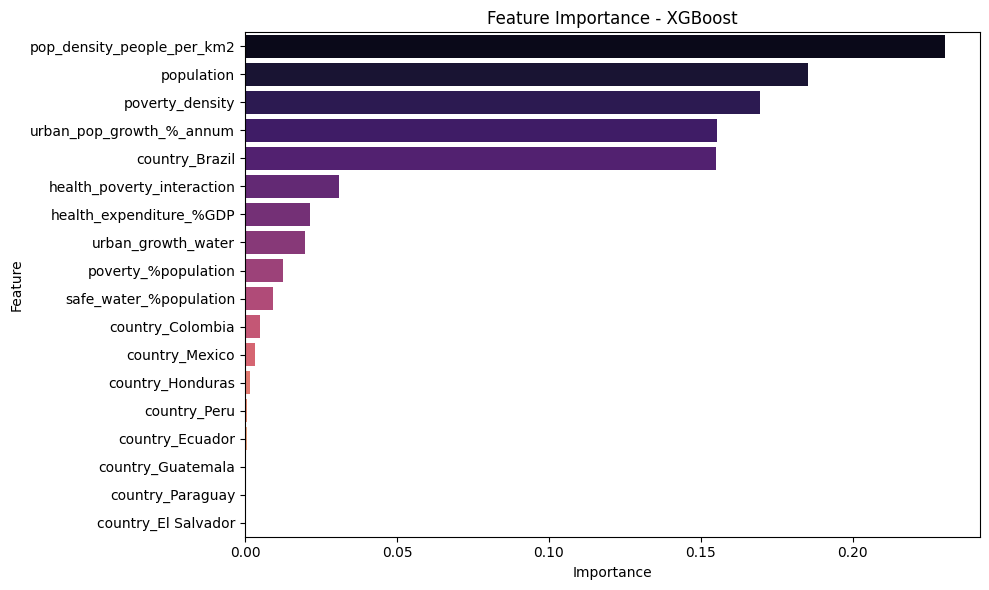

In [ ]:
feat_imp_reg = xgb_ottimizzato_reg.feature_importances_
feat_names_reg = X_reg.columns
feat_imp_df_reg = pd.DataFrame({'Feature': feat_names_reg, 'Importance': feat_imp_reg})
feat_imp_df_reg = feat_imp_df_reg.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feat_imp_df_reg, palette='magma', legend=False)
plt.title('Feature Importance - XGBoost')
plt.tight_layout()
plt.show()

To interpret the behavior of the optimized XGBoost regressor, we examined the feature importance scores derived from the final trained model. These scores reveal which variables most contributed to predicting the **total number of Dengue cases** across the 10-country dataset.

The most relevant predictors were:

1. **pop_density_people_per_km2** – overall population density, which increases the probability of human–mosquito interaction and accelerates epidemic spread in dense urban areas.
2. **population** – total country-level population, reflecting the size of the susceptible pool and potential epidemic magnitude.
3. **poverty_density** – a compound measure of economic vulnerability in relation to population distribution; high values suggest areas where living conditions might favor vector proliferation.
4. **urban_pop_growth_%_annum** – the annual rate of urban population growth, indicative of rapid urbanization, informal settlements, and vector habitat expansion.
5. **country_Brazil** – the only country dummy with high importance, possibly due to its large case volume and regional heterogeneity.

Lower-ranked features include variables such as **health_expenditure_%GDP**, **safe_water_%population**, and dummy encodings for countries like **El Salvador** and **Paraguay**, suggesting minimal predictive power for these dimensions within the current modeling framework.


From a theoretical epidemiological perspective, we anticipated **climatic and ecological factors** (such as temperature, humidity, rainfall) to be crucial, as they directly affect mosquito breeding and virus transmission. However, these variables were **not available** in the current dataset.

Consequently, the model relies entirely on **structural and socio-demographic factors**. The emergence of **population density**, **urban growth**, and **poverty-related indicators** as dominant features supports well-established theories in public health:

- Densely populated areas facilitate faster transmission cycles.
- Rapid urban expansion often lacks infrastructure, leading to stagnant water, poor sanitation, and increased vector breeding sites.
- Poverty limits access to prevention, timely treatment, and resilient housing—amplifying the impact of Dengue outbreaks.

The XGBoost model demonstrates strong alignment with public health literature: **social vulnerability and spatial concentration** are key predictors of Dengue incidence in the absence of real-time environmental triggers.

While the absence of climatic data limits temporal responsiveness, the model effectively captures **baseline structural risks** and may serve as a valuable tool for **long-term vulnerability mapping** and **resource prioritization** across countries.

# Interactive SEIR with Vector Dynamics

To complement our data-driven analysis, we implemented a **mechanistic epidemiological model**, specifically a **SEIR model with vector transmission**, to simulate and visualize the progression of Dengue outbreaks under biologically realistic assumptions.

## What is the SEIR Model with Vectors?

The SEIR model expands the classic SIR framework by introducing an **exposed (E)** compartment for individuals who are infected but not yet infectious. In the context of Dengue, we further extend the model by explicitly representing the **mosquito population**, which is responsible for transmitting the virus between humans.

The model consists of the following compartments:

1) Human Population:
- **S** – Susceptible: individuals who can contract Dengue,  
- **E** – Exposed: infected but not yet infectious (incubation period),  
- **I** – Infected: currently infectious,  
- **R** – Recovered: no longer infectious and assumed immune.

2) Vector Population (Mosquitoes):
- **S<sub>v</sub>** – Susceptible vectors,  
- **E<sub>v</sub>** – Exposed vectors (infected but not yet infectious),  
- **I<sub>v</sub>** – Infected vectors capable of transmitting the virus.

The model is governed by several key parameters:

- **β<sub>hv</sub>** – transmission rate from infected mosquito to human,  
- **β<sub>vh</sub>** – transmission rate from infected human to mosquito,  
- **σ** – rate at which exposed humans become infectious (1/incubation period),  
- **γ** – human recovery rate,  
- **σ<sub>v</sub>** – rate at which exposed mosquitoes become infectious,  
- **μ<sub>v</sub>** – mosquito mortality rate.

These parameters determine the **dynamics of disease spread** within and between the human and vector populations.
## Objectives of the Simulation

In this project, we use the SEIR model with vector transmission to:

- **Simulate vector-borne outbreaks** of Dengue in selected countries and years,  
- **Visualize dynamic interactions** between human and mosquito compartments over time,  
- **Assess sensitivity** to key parameters such as transmission rates and vector lifespan,  
- **Explore intervention scenarios** such as vector control (increasing μ<sub>v</sub>) or reduced transmission (lower β).

## Implementation Overview

We use the `odeint` solver from `scipy.integrate` to numerically solve the SEIR-vector system of differential equations. The interactive interface allows users to:

- Select a **country** and **year** from the dataset,  
- Adjust **transmission, recovery, and incubation rates** using sliders,  
- Vary **mosquito mortality**,  
- Set the number of days to simulate,  
- **Visualize** how changes in parameters impact the trajectory of both human and vector infections.

This tool supports **hypothetical scenario testing** and emphasizes the importance of integrated vector management and timely interventions in controlling Dengue transmission.




In [23]:
def seir_vector_model(y, t, beta_hv, beta_vh, sigma, gamma, sigma_v, mu_v):
    S, E, I, R, Sv, Ev, Iv = y
    Nh = S + E + I + R
    Nv = Sv + Ev + Iv

    dSdt  = -beta_hv * S * Iv / Nv
    dEdt  =  beta_hv * S * Iv / Nv - sigma * E
    dIdt  =  sigma * E - gamma * I
    dRdt  =  gamma * I

    dSvdt = -beta_vh * Sv * I / Nh
    dEvdt =  beta_vh * Sv * I / Nh - sigma_v * Ev
    dIvdt =  sigma_v * Ev - mu_v * Iv

    return [dSdt, dEdt, dIdt, dRdt, dSvdt, dEvdt, dIvdt]

In [24]:
def run_seir_simulation(df, country, year,
                        beta_hv=0.3, beta_vh=0.2,
                        sigma=1/5, gamma=1/7,
                        sigma_v=1/10, mu_v=1/14,
                        days=180):

    row = df[(df['country'] == country) & (df['year'] == year)]
    if row.empty:
        print("Dati non trovati.")
        return

    Nh = row['population'].values[0]
    I0 = row['dengue_cases'].values[0]
    E0 = I0 * 1.5
    R0 = 0
    S0 = Nh - E0 - I0 - R0

    Nv = Nh * 2
    Iv0 = I0 * 3
    Ev0 = Iv0 * 1.5
    Sv0 = Nv - Ev0 - Iv0

    y0 = [S0, E0, I0, R0, Sv0, Ev0, Iv0]
    t = np.linspace(0, days, days)

    result = odeint(seir_vector_model, y0, t,
                    args=(beta_hv, beta_vh, sigma, gamma, sigma_v, mu_v))

    S, E, I, R, Sv, Ev, Iv = result.T

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(t, I, 'r', label='Infected Humans')
    plt.plot(t, Iv, 'orange', label='Infected Vectors')
    plt.plot(t, S, 'b--', label='Susceptible Humans')
    plt.plot(t, R, 'g--', label='Recovered Humans')
    plt.title(f"SEIR Model with Vector – {country} ({year})")
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
def interactive_seir_simulation(df):
    country_widget = Dropdown(options=df['country'].unique(), value='Brazil', description='Country:')
    year_widget = Dropdown(options=sorted(df['year'].unique()), value=2024, description='Year:')
    days_widget = IntSlider(min=30, max=720, step=30, value=180, description='Days:')

    beta_hv_widget = FloatSlider(min=0.01, max=1.0, step=0.01, value=0.3, description='β_hv:')
    beta_vh_widget = FloatSlider(min=0.01, max=1.0, step=0.01, value=0.2, description='β_vh:')
    sigma_widget   = FloatSlider(min=0.01, max=1.0, step=0.01, value=1/5, description='σ (E→I):')
    gamma_widget   = FloatSlider(min=0.01, max=1.0, step=0.01, value=1/7, description='γ (rec):')
    sigma_v_widget = FloatSlider(min=0.01, max=1.0, step=0.01, value=1/10, description='σ_v:')
    mu_v_widget    = FloatSlider(min=0.01, max=1.0, step=0.01, value=1/14, description='μ_v:')

    def update_simulation(country, year, beta_hv, beta_vh, sigma, gamma, sigma_v, mu_v, days):
        run_seir_simulation(df, country, year, beta_hv, beta_vh, sigma, gamma, sigma_v, mu_v, days)

    interact(update_simulation,
             country=country_widget,
             year=year_widget,
             beta_hv=beta_hv_widget,
             beta_vh=beta_vh_widget,
             sigma=sigma_widget,
             gamma=gamma_widget,
             sigma_v=sigma_v_widget,
             mu_v=mu_v_widget,
             days=days_widget)

In [2]:
interactive_seir_simulation(dengue)

NameError: name 'interactive_seir_simulation' is not defined

### Case Study – Brazil: Vector-Based SEIR Simulation

This simulation explores Dengue transmission dynamics in Brazil during 2024 using a compartmental SEIR model that explicitly includes both the human and mosquito populations. The model accounts for key biological stages: susceptible, exposed, infected, and recovered individuals in humans, and susceptible, exposed, and infected vectors.

We evaluate how changes in vector-related parameters affect the course of an outbreak. In particular, we simulate three scenarios with different values of transmission probabilities and vector mortality to assess their impact on the shape and intensity of the epidemic curve.

---

#### Scenario 1 – Reference Scenario (Baseline Dynamics)

- **Vector-to-human transmission rate (β<sub>hv</sub>)**: 0.3  
- **Human-to-vector transmission rate (β<sub>vh</sub>)**: 0.2  
- **Human incubation rate (σ)**: 1/5  
- **Human recovery rate (γ)**: 1/7  
- **Vector incubation rate (σ<sub>v</sub>)**: 1/10  
- **Vector mortality rate (μ<sub>v</sub>)**: 1/14  

This scenario serves as a baseline with plausible biological assumptions. The outbreak develops with a marked increase in both human and mosquito infections, followed by a natural decline as transmission chains are progressively interrupted. A noticeable time lag between peaks in vector and human infections reflects the incubation periods in both populations.

---

#### Scenario 2 – Increased Human-to-Vector Transmission

- **β<sub>vh</sub>** raised to **0.4**

Here, the efficiency with which mosquitoes become infected after biting a contagious human is increased. This accelerates the cycle of infection between hosts and vectors, producing a sharper, earlier epidemic peak and a higher total number of infections. The simulation illustrates how small variations in transmission probabilities can significantly affect outbreak magnitude and speed.

---

#### Scenario 3 – Reduced Vector Lifespan (Control Intervention)

- **μ<sub>v</sub>** increased to **1/7**

In this scenario, we simulate the effects of vector control interventions such as insecticide spraying or habitat reduction. Increasing mosquito mortality shortens the infectious period of vectors, thereby reducing the chance of transmission. The epidemic curve becomes flatter and more prolonged, with fewer individuals affected overall. This outcome demonstrates the potential effectiveness of environmental and entomological control strategies.

---

### Interpretation

These simulations highlight the critical role of mosquito biology in shaping Dengue outbreaks. Key insights include:

- **Higher transmission probabilities** lead to faster and more extensive outbreaks.  
- **Shorter vector lifespan** can interrupt the infection cycle and limit epidemic spread.  
- **Incubation periods** in both hosts and vectors introduce time delays that influence the timing of epidemic peaks.

The model underscores the importance of **vector-focused interventions** in mitigating disease burden, especially in the absence of widespread vaccination. Actions aimed at reducing mosquito population size, limiting their contact with humans, or shortening their lifespan can be highly effective in altering the epidemic trajectory. This analysis reinforces the need for proactive and targeted public health strategies in Dengue-endemic regions.



# Conclusions

This study aimed to investigate the determinants and dynamics of Dengue transmission across ten Latin American countries during the period 2020–2024. By combining **statistical modeling**, **machine learning**, and **epidemiological simulation**, we developed a comprehensive, multi-layered analysis pipeline.

We began by collecting, integrating, and cleaning diverse datasets covering:
- **Epidemiological data** (Dengue cases, incidence),
- **Socio-demographic indicators** (population, density, poverty),
- **Health system variables** (expenditure, access to water).

We constructed derived features such as **log-scaled population**, **poverty density**, and **health-environment interactions**, which later proved useful in modeling.

## Classification Model: Risk Prediction

Using a **Logistic Regression** and a **Random Forest Classifier**, we predicted a categorical **Dengue risk level** ("low", "medium", "high").

- The Random Forest performed best, achieving strong classification metrics.
- The most important features were:  
  - **Urban population growth**,  
  - **Population density**,  
  - **Poverty-related indicators**.

These highlight the **social determinants** of Dengue risk more than biological or environmental triggers (which were absent in this dataset).

## Regression Model: Estimating Case Counts

We modeled the actual **number of Dengue cases** using **XGBoost**, both in raw and log-transformed form.

- The optimized model achieved a **reasonable R² (~0.52)** in real scale.
- Again, features such as **population**, **urban growth**, and **poverty density** were the key predictors.
- Some overfitting was noted in the log scale, suggesting challenges with extreme values or under-reporting.

## Mechanistic Modeling: SEIR Simulation with Vector Dynamics

To complement the empirical analysis, we developed a **mechanistic SEIR model** that explicitly incorporates vector-borne transmission, accounting for both human and mosquito populations. This approach allowed us to simulate Dengue outbreaks under varying biological and epidemiological assumptions, and to evaluate the impact of key parameters.

Using **Brazil in 2024** as a reference case, the simulations showed how small changes in vector behavior or lifespan can significantly alter the scale and timing of outbreaks. In particular:

- Increasing vector mortality or reducing transmission probabilities leads to **smaller and delayed epidemics**,
- Higher efficiency in vector-to-human transmission accelerates and amplifies the outbreak.

These insights highlight the critical importance of **vector control strategies**—such as environmental sanitation, insecticide use, and habitat disruption—in mitigating Dengue transmission. Mechanistic modeling provides a valuable tool for scenario testing and supports evidence-based planning for public health interventions.


## Key Insights

1. **Dengue is heavily influenced by structural factors**: urbanization, poverty, and population concentration are strong predictors of both risk and total cases.
2. **Machine learning models** can effectively predict and classify Dengue outcomes using socio-demographic data alone.
3. **Mechanistic models** complement predictive models by explaining *how* disease might evolve under different transmission scenarios.

## Limitations & Future Work

- The absence of **climatic data** (e.g., temperature, rainfall, humidity) limits ecological accuracy.
- **Vector dynamics** (mosquito populations, Aedes distribution) were not included.
- We assume perfect data quality, but **under-reporting** and **inconsistent case definitions** likely affected ground truth labels.

In future work, the integration of **real-time environmental data**, **vector surveillance**, and **climate modeling** could provide a more holistic understanding of Dengue epidemics.

## Final Remarks

This project demonstrates how combining data science techniques with public health theory can uncover **valuable insights** and support **evidence-based decision-making**. By identifying high-risk populations and simulating epidemic scenarios, we contribute to the broader goal of **anticipating and mitigating vector-borne disease outbreaks** in vulnerable regions.
